## Grupo:
## Andrea Blatter, Fernanda Pucheta, Cesar Zamboni

In [1]:
#!pip install xgboost
#!pip install seaborn 
#!pip install matplotlib

In [2]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings(action="ignore")


In [3]:
### Loading Data
data = pd.read_csv('data/norech4w_20190908_abt_data.txt',sep='|')
tag = pd.read_csv('data/norech4w_20190908_abt_tag.txt',sep='|')

## Preparamos el tag y el dataset completo

In [4]:
data.head()

SUSCRIBER_KEY FECHA_CORTE  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
0  E_67773005_20190427   08-SEP-19       9.41650     -82.52070     -82.52000   
1  E_65364767_20150701   08-SEP-19       8.58480     -82.38850     -81.82747   
2  E_67094312_20150701   08-SEP-19       8.79528     -80.14711     -79.65000   
3  E_66513730_20150701   08-SEP-19       9.08320     -79.59240     -79.47068   
4  E_67337458_20181130   08-SEP-19       9.08320     -79.59240     -79.51973   

   LON_CITY_BTS VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION SOURCE  ...  \
0       9.43000      2 - GOLD         3-DO               VD3    NEW  ...   
1       8.22436  1 - PLATINUM        1-HCV              HCV1    NEW  ...   
2       8.95000    3 - SILVER         5-PV               PV1    NEW  ...   
3       9.05032      2 - GOLD         3-DO               DO4    NEW  ...   
4       8.99360    3 - SILVER        7-LOW               OH1    NEW  ...   

  PACK_DATA_EXP_W3 PACK_DATA_EXP_W4 PACK_DATA_EXP_W5 PACK_DATA_EXP_W6  \
0               11                7               13               11   
1                9                9               11               11   
2                0                0                0                0   
3               11               12                8                9   
4                0                0                0                4   

   PACK_DATA_EXP_W7  PACK_DATA_EXP_W8  PACK_DATA_EXP_W9  PACK_DATA_EXP_W10  \
0                 9                11                12                  9   
1                15                 9                13                 15   
2                 0                 0                 0                  0   
3                10                11                13                  8   
4                11                 0                 0                  0   

   PACK_DATA_EXP_W11  PACK_DATA_EXP_W12  
0                  9                  0  
1                 14                 13  
2                  0                  0  
3                 10                 10  
4                  0                  0  

[5 rows x 212 columns]

In [5]:
tag.head()

SUSCRIBER_KEY  PREP_RECH_AMT_W_0  PREP_RECH_AMT_W_1  \
0  CW_DPRE_67759547_20150701                6.0                7.5   
1  CW_DPRE_66948838_20171126                3.0                0.0   
2  CW_DPRE_68858157_20180607                0.0                3.0   
3  CW_DPRE_65464761_20181014                0.0                4.5   
4  CW_DPRE_67448216_20150701                5.0                0.0   

   PREP_RECH_AMT_W_2  PREP_RECH_AMT_W_3  PREP_RECH_Q_EVT_W_0  \
0                6.0                5.0                    4   
1                1.5                6.3                    1   
2                0.0                0.0                    0   
3                0.0                0.0                    0   
4                3.0                0.0                    1   

   PREP_RECH_Q_EVT_W_1  PREP_RECH_Q_EVT_W_2  PREP_RECH_Q_EVT_W_3  
0                    5                    3                    1  
1                    0                    1                    4  
2                    1                    0                    0  
3                    2                    0                    0  
4                    0                    1                    0

In [6]:
'''
Observo que los campos SUSCRIBER_KEY tienen distinto formato en ambos data sets
Verifico si los 6 primeros digitos del campo SUSCRIBER_KEY en tag son todos iguales.
'''
tmp = tag['SUSCRIBER_KEY'].str[:6]
tmp.unique()

array(['CW_DPR'], dtype=object)

In [7]:
#Como sí son todos iguales y no aportan información los elimino para que coincidan con los del dataset data
tag['SUSCRIBER_KEY'] = tag['SUSCRIBER_KEY'].str[6:]

In [8]:
tag.head()

SUSCRIBER_KEY  PREP_RECH_AMT_W_0  PREP_RECH_AMT_W_1  \
0  E_67759547_20150701                6.0                7.5   
1  E_66948838_20171126                3.0                0.0   
2  E_68858157_20180607                0.0                3.0   
3  E_65464761_20181014                0.0                4.5   
4  E_67448216_20150701                5.0                0.0   

   PREP_RECH_AMT_W_2  PREP_RECH_AMT_W_3  PREP_RECH_Q_EVT_W_0  \
0                6.0                5.0                    4   
1                1.5                6.3                    1   
2                0.0                0.0                    0   
3                0.0                0.0                    0   
4                3.0                0.0                    1   

   PREP_RECH_Q_EVT_W_1  PREP_RECH_Q_EVT_W_2  PREP_RECH_Q_EVT_W_3  
0                    5                    3                    1  
1                    0                    1                    4  
2                    1                    0                    0  
3                    2                    0                    0  
4                    0                    1                    0

In [9]:
'''
Por conocimiento de negocio se sabe que las columnas que contienen las letras AMT no son necesarias, 
asi que las borramos con un bucle for.
'''
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)
tag.head()

SUSCRIBER_KEY  PREP_RECH_Q_EVT_W_0  PREP_RECH_Q_EVT_W_1  \
0  E_67759547_20150701                    4                    5   
1  E_66948838_20171126                    1                    0   
2  E_68858157_20180607                    0                    1   
3  E_65464761_20181014                    0                    2   
4  E_67448216_20150701                    1                    0   

   PREP_RECH_Q_EVT_W_2  PREP_RECH_Q_EVT_W_3  
0                    3                    1  
1                    1                    4  
2                    0                    0  
3                    0                    0  
4                    1                    0

In [10]:
#creamos una nueva columna llamada total, que suma los  valores de las recargas acumuladas por semana. 
#Con axis=1 le decimos a sum() que la suma es por registro y no por columna
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)
tag['Total']

0         13
1          6
2          1
3          2
4          2
5          7
6          2
7          0
8          1
9          4
10         5
11         3
12         3
13         1
14         0
15         0
16         2
17         6
18         2
19         5
20         0
21         4
22         1
23         4
24         0
25         0
26         4
27         5
28         0
29         5
          ..
967310     3
967311     4
967312     2
967313     2
967314     1
967315     3
967316     3
967317     1
967318     2
967319     4
967320     0
967321     0
967322     5
967323     0
967324     5
967325     4
967326     4
967327     2
967328     9
967329     1
967330     3
967331     0
967332     0
967333     4
967334     2
967335     0
967336     8
967337     4
967338     5
967339     1
Name: Total, Length: 967340, dtype: int64

In [11]:
#entonces ahora borramos todas las columnas que contenga EVT, que son la cantidad de recargas acumuladas por semana, 
#al tener su valor acumulado ya estas columnas no nos sirven
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

In [12]:
tag.head()

SUSCRIBER_KEY  Total
0  E_67759547_20150701     13
1  E_66948838_20171126      6
2  E_68858157_20180607      1
3  E_65464761_20181014      2
4  E_67448216_20150701      2

In [13]:
#vamos a guardar en total, false para todos aquellos cuya sumatoria sea 0, y true para los que tengan un total mayor a 1 
tag['Total']=tag['Total']<1
tag['Total']

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7          True
8         False
9         False
10        False
11        False
12        False
13        False
14         True
15         True
16        False
17        False
18        False
19        False
20         True
21        False
22        False
23        False
24         True
25         True
26        False
27        False
28         True
29        False
          ...  
967310    False
967311    False
967312    False
967313    False
967314    False
967315    False
967316    False
967317    False
967318    False
967319    False
967320     True
967321     True
967322    False
967323     True
967324    False
967325    False
967326    False
967327    False
967328    False
967329    False
967330    False
967331     True
967332     True
967333    False
967334    False
967335     True
967336    False
967337    False
967338    False
967339    False
Name: Total, Length: 967

In [14]:
#renombramos la columna total por target
tag.rename(columns={'Total':'Target'},inplace=True)
tag.head()

SUSCRIBER_KEY  Target
0  E_67759547_20150701   False
1  E_66948838_20171126   False
2  E_68858157_20180607   False
3  E_65464761_20181014   False
4  E_67448216_20150701   False

In [15]:
#en vez de tenerlo como true o false es mas correcto manejarlo como 0s y 1s 
tag['Target'] = tag['Target'].astype(int)
tag.head()

SUSCRIBER_KEY  Target
0  E_67759547_20150701       0
1  E_66948838_20171126       0
2  E_68858157_20180607       0
3  E_65464761_20181014       0
4  E_67448216_20150701       0

In [16]:
#y ahora vamos a mergear esta tabla con la tabla data 
# no habria ocurrencias de esta manera pq en data no modificamos el suscriber key entonces nunca se encontrarian dos iguales
#es por eso que agrego la celda de arriba con data['SUSCRIBER_KEY'] = data['SUSCRIBER_KEY'].str[6:]
fulldata = data.merge(tag, on='SUSCRIBER_KEY')
fulldata.head()

SUSCRIBER_KEY FECHA_CORTE  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
0  E_67773005_20190427   08-SEP-19       9.41650     -82.52070     -82.52000   
1  E_65364767_20150701   08-SEP-19       8.58480     -82.38850     -81.82747   
2  E_67094312_20150701   08-SEP-19       8.79528     -80.14711     -79.65000   
3  E_66513730_20150701   08-SEP-19       9.08320     -79.59240     -79.47068   
4  E_67337458_20181130   08-SEP-19       9.08320     -79.59240     -79.51973   

   LON_CITY_BTS VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION SOURCE  ...  \
0       9.43000      2 - GOLD         3-DO               VD3    NEW  ...   
1       8.22436  1 - PLATINUM        1-HCV              HCV1    NEW  ...   
2       8.95000    3 - SILVER         5-PV               PV1    NEW  ...   
3       9.05032      2 - GOLD         3-DO               DO4    NEW  ...   
4       8.99360    3 - SILVER        7-LOW               OH1    NEW  ...   

  PACK_DATA_EXP_W4 PACK_DATA_EXP_W5 PACK_DATA_EXP_W6 PACK_DATA_EXP_W7  \
0                7               13               11                9   
1                9               11               11               15   
2                0                0                0                0   
3               12                8                9               10   
4                0                0                4               11   

   PACK_DATA_EXP_W8  PACK_DATA_EXP_W9  PACK_DATA_EXP_W10  PACK_DATA_EXP_W11  \
0                11                12                  9                  9   
1                 9                13                 15                 14   
2                 0                 0                  0                  0   
3                11                13                  8                 10   
4                 0                 0                  0                  0   

   PACK_DATA_EXP_W12  Target  
0                  0       0  
1                 13       0  
2                  0       0  
3                 10       0  
4                  0       1  

[5 rows x 213 columns]

In [17]:
#con este comando vemos cantidad de filas x columnas, ahora tenemos una columna mas en la tabla data, la columna target
fulldata.shape

(967340, 213)

In [18]:
#tras haber hecho el merge de ambas tablas eliminamos los dataframes data y tag
del tag
del data

## Análisis y Transformación de Datos

### Columnas que no aportan nada

In [19]:
#veremos aquellas columnas que tienen el mismo valor en todas las filas (un unico valor, por eso el 1)
#entonces sabremos que estas columnas no aportan nada
[x for x in fulldata.columns if fulldata[x].nunique()==1]

['FECHA_CORTE', 'SOURCE']

### Por conocimiento de Dominio

In [20]:
#por lo que ya nos dice el enunciado vamos a eliminar todas las columnas que no se usan según conocimiento del negocio
to_remove=["SPNDG_VOI_ONNET_ARPU_M1",
"SPNDG_VOI_ONNET_ARPU_M2",
"SPNDG_VOI_ONNET_ARPU_M3",
"SPNDG_VOI_OFFNET_ARPU_M1",
"SPNDG_VOI_OFFNET_ARPU_M2",
"SPNDG_VOI_OFFNET_ARPU_M3",
"USE_LCL_VOI_AMT_M1",
"USE_LCL_VOI_AMT_M2",
"USE_LCL_VOI_AMT_M3",
"SPNDG_VOI_INTRNTL_ARPU_M1",
"SPNDG_VOI_INTRNTL_ARPU_M2",
"SPNDG_VOI_INTRNTL_ARPU_M3",
"SMS_OFFNET_EXP_ARPU_AMT_M1",
"SMS_OFFNET_EXP_ARPU_AMT_M2",
"SMS_OFFNET_EXP_ARPU_AMT_M3",
"SMS_ONNET_EXP_ARPU_AMT_M1",
"SMS_ONNET_EXP_ARPU_AMT_M2",
"SMS_ONNET_EXP_ARPU_AMT_M3",
"EXPDTR_DATA_ARPU_AMT_M1",
"EXPDTR_DATA_ARPU_AMT_M2",
"EXPDTR_DATA_ARPU_AMT_M3"]


### Eliminamos las columnas

In [21]:
#con esto eliminamos todas las columnas que eran innecesarias, y las 2 que encontramos que tenian el mismo valor
# para todas sus filas 
to_remove = to_remove + [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [22]:
to_remove

['SPNDG_VOI_ONNET_ARPU_M1',
 'SPNDG_VOI_ONNET_ARPU_M2',
 'SPNDG_VOI_ONNET_ARPU_M3',
 'SPNDG_VOI_OFFNET_ARPU_M1',
 'SPNDG_VOI_OFFNET_ARPU_M2',
 'SPNDG_VOI_OFFNET_ARPU_M3',
 'USE_LCL_VOI_AMT_M1',
 'USE_LCL_VOI_AMT_M2',
 'USE_LCL_VOI_AMT_M3',
 'SPNDG_VOI_INTRNTL_ARPU_M1',
 'SPNDG_VOI_INTRNTL_ARPU_M2',
 'SPNDG_VOI_INTRNTL_ARPU_M3',
 'SMS_OFFNET_EXP_ARPU_AMT_M1',
 'SMS_OFFNET_EXP_ARPU_AMT_M2',
 'SMS_OFFNET_EXP_ARPU_AMT_M3',
 'SMS_ONNET_EXP_ARPU_AMT_M1',
 'SMS_ONNET_EXP_ARPU_AMT_M2',
 'SMS_ONNET_EXP_ARPU_AMT_M3',
 'EXPDTR_DATA_ARPU_AMT_M1',
 'EXPDTR_DATA_ARPU_AMT_M2',
 'EXPDTR_DATA_ARPU_AMT_M3',
 'FECHA_CORTE',
 'SOURCE']

In [23]:
fulldata.drop(columns=to_remove,inplace=True)

In [24]:
#Eliminamos las columnas PREP_RECH_Q_EVT dejando la granularidad mas chica
to_remove_PREP_RECH_Q_EV=['PREP_RECH_Q_EVT_X1',
                          'PREP_RECH_Q_EVT_X2',
                          'PREP_RECH_Q_EVT_X3',
                          'PREP_RECH_Q_MON_12W',
                          'PREP_RECH_Q_TUE_12W',
                          'PREP_RECH_Q_WEN_12W',
                          'PREP_RECH_Q_THUR_12W',
                          'PREP_RECH_Q_FRI_12W',
                          'PREP_RECH_Q_SAT_12W',
                          'PREP_RECH_Q_SUN_12W',
                         ]
fulldata.drop(columns=to_remove_PREP_RECH_Q_EV,inplace=True)

In [25]:
#de 213 columnas pasamos a 180, good! 
fulldata.shape

(967340, 180)

### Chequeamos duplicados para todas las columnas

In [26]:
#vemos si hay duplicados
fulldata.duplicated().any()

False

In [27]:
#chequeamos la cantidad de filas antes de aplicar drop_duplicates
fulldata.shape

(967340, 180)

In [28]:
#nos aseguramos que la cantidad de registros efectivamente es el mismo
fulldata.drop_duplicates().shape

(967340, 180)

### Ahora Chequeemos faltantes

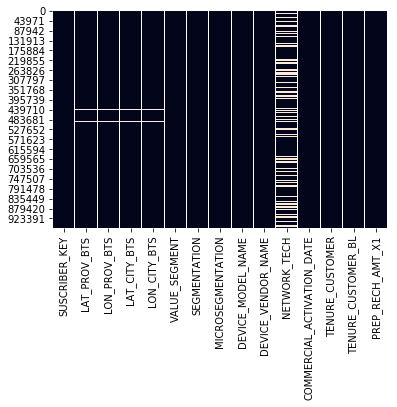

In [29]:
#haremos un heatmap con las primeras 15 columnas identificando donde hay nulos 
#donde vemos mas blancos es que hay mas nulos
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull(), cbar=False)
#vemos asi que network_tech tiene muuuchos nulos 

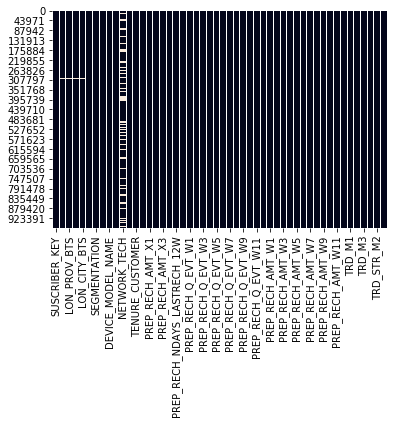

In [30]:
#ahora vamos a hacer lo mismo pero con las primeras 50 columnas
sns.heatmap(fulldata[fulldata.columns[0:50]].isnull(), cbar=False)

In [31]:
#tomarwemos una muestra de fulldata de un 30%
sampledata = fulldata.sample(frac=0.3)

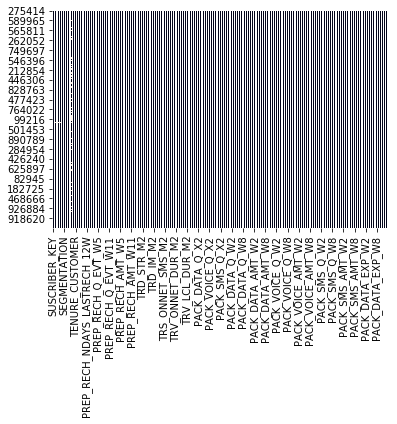

In [32]:
#y de esta muestra haremos un heatmap para poder visualizar mejor 
sns.heatmap(sampledata.isnull(), cbar=False)

In [33]:
#contaremos la cantidad de nulos para cada columna 
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

In [34]:
#y haremos una serie con estos valores para graficarlo como grafico de barras
missing = pd.Series(nullcount)

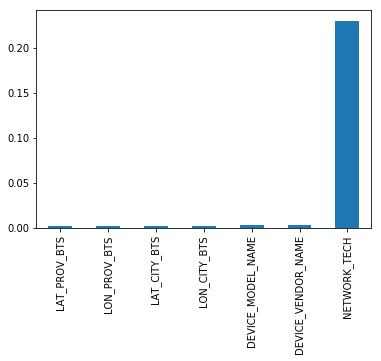

In [35]:
#ahora graficamos valores relativos solamente de las variables que contienen nulos, por eso usamos div
missing[missing>0].div(fulldata.shape[0]).plot.bar()

### Imputamos valores en variables con nulos

In [36]:
#como hay muuuchos nulos en network_tech vamos a trabajar con esto 
#sacaremos un promedio de sus valores y vemos que la tecnologia con mas ocurrencias es LTE
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.467369
3G     0.271684
NaN    0.230260
2G     0.030686
Name: NETWORK_TECH, dtype: float64

In [37]:
#entonces para cada valor nulo existente en network_tech, le asignaremos el valor LTE, esta es una manera de eliminar nulos
fulldata.loc[fulldata['NETWORK_TECH'].isnull(),'NETWORK_TECH']='LTE'

In [38]:
#obtenemos la nueva distribucion luego de asignar LTE
fulldata['NETWORK_TECH'].value_counts(normalize=True)

LTE    0.697630
3G     0.271684
2G     0.030686
Name: NETWORK_TECH, dtype: float64

In [39]:
#ahora trabajaremos con las columnas DEVICE_MODEL_NAME y DEVICE_VENDOR_NAME que tambien poseen muchos nulos
#device model name - distrucion por modelo
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

NOT_IDENTIFIED                                  0.134446
GALAXY GRAND PRIME DUOS (SM-G532M DS)           0.105600
GALAXY GRAND NEO (GT-I9060C)                    0.028653
GALAXY J7 DUOS LTE (SM-J700MDS)                 0.023998
Y5 2018 (DRA-LX3)                               0.020862
GALAXY J2 PRIME (SM-G532M)                      0.019989
Y9 2019 (JKM-LX3)                               0.019400
Y6 2 (CAM-L23)                                  0.016593
JENNY TV 2.8                                    0.015843
GALAXY J1 ACE (SM-J106B DL)                     0.015088
GALAXY J7 NEO (SM-J701M DS)                     0.013123
GALAXY J1 (SM-J111MDS)                          0.013067
P20 LITE (ANE-LX3)                              0.012781
Y5 2017 (MYA-L23)                               0.012523
GALAXY J5 (SM-J500M)                            0.012192
GALAXY J2 PRO 2018 (SM-J250M DS)                0.011847
GALAXY J7 PRIME (SM-G610M DS)                   0.011809
MATE 10 LITE (RNE-L03)         

In [40]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG            0.502104
HUAWEI             0.173219
NOT_IDENTIFIED     0.134446
LG                 0.051731
BLU                0.030831
NOKIA              0.027295
APPLE              0.017449
UNKNOWN            0.010079
GREYMARKET         0.006786
ALCATEL            0.006112
HYUNDAI            0.006005
AZUMI              0.004592
SIEMENS            0.003546
NaN                0.002868
TELEONE            0.002032
SONYERICSSON       0.001465
BLACKBERRY         0.001298
TELEGO             0.001188
MOTOROLA           0.001007
CAT                0.001005
ZTE                0.000970
SONY               0.000906
LANIX              0.000895
J-MAX              0.000645
OMES               0.000544
YXTEL              0.000487
TINMO              0.000422
TECNO              0.000402
YEZZ               0.000392
DAEWOO             0.000386
                     ...   
DISKO              0.000001
JINGWAH            0.000001
ELEPHONE           0.000001
GOWIN              0.000001
NKTEL              0

In [41]:
'''
observamos que en ambas variables se utiliza el valor NOT_IDENTIFIED para los registros 
que no poseen datos del device, entonces en este caso, a los valores nulos los 
reemplazaremos por NOT_IDENTIFIED.
'''
fulldata.loc[fulldata['DEVICE_MODEL_NAME'].isnull(),'DEVICE_MODEL_NAME']='NOT_IDENTIFIED'
fulldata.loc[fulldata['DEVICE_VENDOR_NAME'].isnull(),'DEVICE_VENDOR_NAME']='NOT_IDENTIFIED'

In [42]:
# Asigno en una categoria Others los que no llega a los que los vendors tiene una representacion menor que 100 
# creo la nueva categoria Others 
# contar cuantos hay y los que no llegan a 100 los reemplazo por la categoria Other
vendors = fulldata['DEVICE_VENDOR_NAME'].value_counts()
vendors_to_replace = vendors[vendors<100].index
fulldata.loc[fulldata['DEVICE_VENDOR_NAME'].isin(vendors_to_replace),'DEVICE_VENDOR_NAME'] ='OTHER'

In [43]:
#hago lo mismo con la columna DEVICE_MODEL_NAME
# contar cuantos hay y los que no llegan a 100 los reemplazo por la categoria Other
models = fulldata['DEVICE_MODEL_NAME'].value_counts()
models_to_replace = models[models<100].index
fulldata.loc[fulldata['DEVICE_MODEL_NAME'].isin(models_to_replace),'DEVICE_MODEL_NAME'] ='OTHER'

In [44]:
#las otras 4 columnas que contienen valores nulos son LAT_PROV_BTS , LON_PROV_BTS, LAT_CITY_BTS y LON_CITY_BTS
fulldata[fulldata.columns[:5]]

SUSCRIBER_KEY  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
0       E_67773005_20190427       9.41650     -82.52070     -82.52000   
1       E_65364767_20150701       8.58480     -82.38850     -81.82747   
2       E_67094312_20150701       8.79528     -80.14711     -79.65000   
3       E_66513730_20150701       9.08320     -79.59240     -79.47068   
4       E_67337458_20181130       9.08320     -79.59240     -79.51973   
5       E_65181285_20180422       8.58480     -82.38850     -82.42000   
6       E_68033218_20190224       9.08320     -79.59240     -79.51973   
7       E_66973254_20180923       8.65950     -81.77870     -81.85750   
8       E_67395190_20171101       8.62660     -80.36590     -80.35727   
9       E_67901068_20170509       8.62660     -80.36590     -80.35727   
10      E_67678847_20170305       9.08320     -79.59240     -79.10083   
11      E_67510158_20150701       9.08320     -79.59240     -79.51973   
12      E_67213118_20190617       8.58480     -82.38850     -82.54492   
13      E_69129806_20170603       8.58480     -82.38850     -82.43330   
14      E_67626024_20150602       9.08320     -79.59240     -79.51973   
15      E_63764117_20150701       8.58480     -82.38850     -82.61991   
16      E_67750901_20170923       8.58480     -82.38850     -82.43330   
17      E_67156321_20150701       9.08320     -79.59240     -79.47068   
18      E_69503488_20160530       9.08320     -79.59240     -79.51973   
19      E_67622839_20181225       9.08320     -79.59240     -79.47068   
20      E_66946667_20150701       8.58480     -82.38850     -82.43330   
21      E_69478724_20161015       9.18520     -80.05350     -79.90011   
22      E_63413816_20180110       8.62660     -80.36590     -80.35727   
23      E_67882549_20190515       8.79528     -80.14711     -79.65000   
24      E_67918889_20180320       8.79528     -80.14711     -79.78333   
25      E_69680799_20190518       8.12310     -81.07550     -80.84067   
26      E_65423800_20190322       8.79528     -80.14711     -79.78333   
27      E_67412057_20190617       8.58480     -82.38850     -82.43330   
28      E_68854346_20190107       9.08320     -79.59240     -79.47068   
29      E_67359095_20150702       8.79528     -80.14711     -79.65000   
...                     ...           ...           ...           ...   
967310  E_67292723_20160612       9.08320     -79.59240     -79.47068   
967311  E_69417644_20180303       8.79528     -80.14711     -79.65000   
967312  E_67771271_20170608       9.08320     -79.59240     -79.47068   
967313  E_67283298_20150701       9.08320     -79.59240     -79.51973   
967314  E_69670475_20190601       8.79528     -80.14711     -79.78333   
967315  E_66943341_20170325       7.59090     -80.36580     -80.44217   
967316  E_63779537_20150714       9.41650     -82.52070     -82.52000   
967317  E_68838816_20170703       8.58480     -82.38850     -82.57025   
967318  E_65241436_20190217       8.58480     -82.38850     -82.61991   
967319  E_65186296_20150702       8.62660     -80.36590     -80.35727   
967320  E_69109210_20160316       8.62660     -80.36590     -80.54609   
967321  E_67821983_20150602       9.08320     -79.59240     -79.51973   
967322  E_66897407_20150701       8.58480     -82.38850     -82.54492   
967323  E_67695495_20160614       9.08320     -79.59240     -79.10083   
967324  E_66877481_20150701       9.08320     -79.59240     -79.51973   
967325  E_66676757_20180518       8.79528     -80.14711     -79.78333   
967326  E_66883802_20160526       9.08320     -79.59240     -79.51973   
967327  E_63400870_20180609       9.08320     -79.59240     -79.51973   
967328  E_68768207_20190428       8.79528     -80.14711     -79.65000   
967329  E_65396445_20180406       9.18520     -80.05350     -79.90011   
967330  E_69663475_20151025       9.18520     -80.05350     -79.90011   
967331  E_69550816_20150701       9.08320     -79.59240     -79.51973   
967332  E_67759893_20181006       9.08320     -79.59240     -79.51973   

## Otros análisis 

In [45]:
fulldata['LAT_PROV_BTS'].value_counts(normalize=True,dropna=False)

9.08320    0.388628
8.79528    0.126905
8.58480    0.122138
9.18520    0.085232
8.62660    0.082285
8.12310    0.056812
9.41650    0.045013
7.59090    0.040008
7.77040    0.028063
7.86810    0.016242
8.65950    0.003806
9.23440    0.002586
NaN        0.002282
Name: LAT_PROV_BTS, dtype: float64

In [46]:
fulldata['LON_PROV_BTS'].value_counts(normalize=True,dropna=False)

-79.59240    0.388628
-80.14711    0.126905
-82.38850    0.122138
-80.05350    0.085232
-80.36590    0.082285
-81.07550    0.056812
-82.52070    0.045013
-80.36580    0.040008
-80.72140    0.028063
-77.83670    0.016242
-81.77870    0.003806
 NaN         0.002282
-78.70164    0.001812
-78.88102    0.000774
Name: LON_PROV_BTS, dtype: float64

In [47]:
#puedo observar que los mismos registros que no proveen informacion sobre latitutd de la provincia
#tampoco lo proveen sobre su longitud. y como no es un numero muy significativo puedo proceder a eliminarlos

#haremos el mismo analisis para ver los nulos de latitud y longitud de ciudad
fulldata['LAT_CITY_BTS'].value_counts(normalize=True,dropna=False)

-79.51973    0.290832
-79.47068    0.073284
-79.90011    0.072965
-79.65000    0.072266
-79.78333    0.043089
-82.43330    0.038177
-82.52000    0.034194
-80.35727    0.026756
-80.96670    0.024378
-82.61991    0.023974
-80.54609    0.021322
-80.26063    0.018746
-79.10083    0.017417
-80.42944    0.016267
-80.27483    0.014285
-79.88333    0.013774
-82.54492    0.010527
-78.05400    0.008867
-81.32163    0.008654
-82.42000    0.007665
-80.41667    0.007443
-77.67270    0.007376
-81.70210    0.007349
-80.51969    0.007205
-82.79940    0.006979
-82.44136    0.006775
-80.44349    0.006729
-82.11769    0.005613
-80.28345    0.005572
-81.86702    0.005382
               ...   
-82.55947    0.003192
-82.57025    0.002937
-81.82747    0.002732
-80.66582    0.002706
-81.21152    0.002634
-80.52097    0.002634
-81.85750    0.002459
-80.84067    0.002295
-80.77936    0.002284
 NaN         0.002282
-82.29959    0.002188
-80.55000    0.002064
-80.02699    0.001997
-80.64524    0.001873
-78.19260 

In [48]:
fulldata['LON_CITY_BTS'].value_counts(normalize=True,dropna=False)

8.99360    0.290832
9.05032    0.073284
9.35451    0.072965
8.95000    0.070042
8.88028    0.043089
8.43330    0.038177
9.43000    0.034194
8.51889    0.026756
8.10000    0.024378
8.48255    0.023974
8.24183    0.021322
8.39733    0.018746
9.17019    0.017417
7.96082    0.016267
7.76472    0.014285
8.80671    0.010527
8.58333    0.009604
8.30190    0.008867
8.01223    0.008654
8.56000    0.007665
7.93333    0.007443
8.13930    0.007376
8.21220    0.007349
8.33209    0.007205
8.74580    0.006979
8.78024    0.006775
8.59299    0.006729
8.94557    0.005613
7.81531    0.005572
8.29063    0.005382
             ...   
8.39791    0.003192
8.50510    0.002937
8.22436    0.002732
8.11143    0.002706
7.99393    0.002634
8.32004    0.002634
9.23440    0.002586
8.89503    0.002459
8.31886    0.002295
7.94052    0.002284
NaN        0.002282
9.55000    0.002225
8.53006    0.002188
8.25814    0.002064
7.53034    0.001997
7.78300    0.001873
8.65525    0.001728
7.47290    0.001578
8.41807    0.001527


In [49]:
#no vemos en las salidas anteriores la cantidad de nulos, entonces llamaremos al metodo isnull y veremos 
#una sumatoria para ver si la cantidad de nulos es igual
fulldata['LAT_CITY_BTS'].isnull().sum()

2207

In [50]:
fulldata['LON_CITY_BTS'].isnull().sum()

2207

In [51]:
fulldata['LAT_PROV_BTS'].isnull().sum()

2207

In [52]:
fulldata['LON_PROV_BTS'].isnull().sum()

2207

In [53]:
#tras ver que es exactamente la misma cantidad de registros los que poseen valores nulos, vamos a proceder a eliminar los 
#mismos ya que consideramos que no nos modificaran considerablemente la muestra 
fulldata.drop(fulldata[fulldata['LAT_PROV_BTS'].isnull()].index, inplace = True)

In [54]:
#habiendo eliminado todos los registros, veremos que ya no poseemos mas valores nulos en ninguna de nuestras columnas
{col:fulldata[col].isnull().sum() for col in fulldata.columns}

{'SUSCRIBER_KEY': 0,
 'LAT_PROV_BTS': 0,
 'LON_PROV_BTS': 0,
 'LAT_CITY_BTS': 0,
 'LON_CITY_BTS': 0,
 'VALUE_SEGMENT': 0,
 'SEGMENTATION': 0,
 'MICROSEGMENTATION': 0,
 'DEVICE_MODEL_NAME': 0,
 'DEVICE_VENDOR_NAME': 0,
 'NETWORK_TECH': 0,
 'COMMERCIAL_ACTIVATION_DATE': 0,
 'TENURE_CUSTOMER': 0,
 'TENURE_CUSTOMER_BL': 0,
 'PREP_RECH_AMT_X1': 0,
 'PREP_RECH_AMT_X2': 0,
 'PREP_RECH_AMT_X3': 0,
 'PREP_RECH_LAST_DAY_12W': 0,
 'PREP_RECH_NDAYS_LASTRECH_12W': 0,
 'PREP_RECH_CHNNL_MODE12W': 0,
 'PREP_RECH_Q_EVT_W1': 0,
 'PREP_RECH_Q_EVT_W2': 0,
 'PREP_RECH_Q_EVT_W3': 0,
 'PREP_RECH_Q_EVT_W4': 0,
 'PREP_RECH_Q_EVT_W5': 0,
 'PREP_RECH_Q_EVT_W6': 0,
 'PREP_RECH_Q_EVT_W7': 0,
 'PREP_RECH_Q_EVT_W8': 0,
 'PREP_RECH_Q_EVT_W9': 0,
 'PREP_RECH_Q_EVT_W10': 0,
 'PREP_RECH_Q_EVT_W11': 0,
 'PREP_RECH_Q_EVT_W12': 0,
 'PREP_RECH_AMT_W1': 0,
 'PREP_RECH_AMT_W2': 0,
 'PREP_RECH_AMT_W3': 0,
 'PREP_RECH_AMT_W4': 0,
 'PREP_RECH_AMT_W5': 0,
 'PREP_RECH_AMT_W6': 0,
 'PREP_RECH_AMT_W7': 0,
 'PREP_RECH_AMT_W8': 0,
 'P

In [55]:
fulldata.shape

(965133, 180)

In [56]:
#aca se fija cuantos registros hay tras hacer drop NaN hay para corroborar que ya no quedan
fulldata.dropna().shape

(965133, 180)

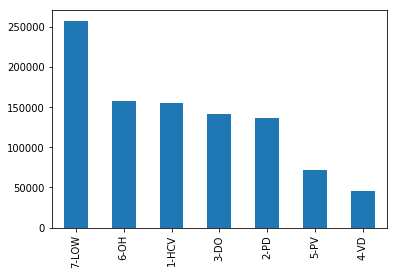

In [57]:
fulldata['SEGMENTATION'].value_counts().plot.bar()

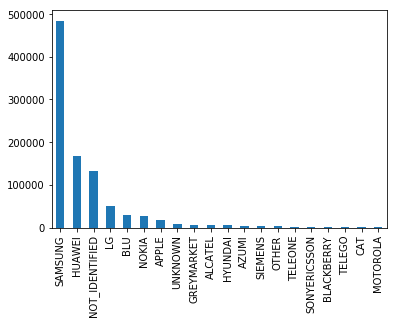

In [58]:
fulldata['DEVICE_VENDOR_NAME'].value_counts()[:20].plot.bar()

## Checkpoint 1

Antes de continuar con otras trasnformaciones y eliminiación de columnas dejamos un punto de control para probar el modelo.


In [59]:
fulldata.shape

(965133, 180)

In [60]:
fulldata.head()

SUSCRIBER_KEY  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
0  E_67773005_20190427       9.41650     -82.52070     -82.52000   
1  E_65364767_20150701       8.58480     -82.38850     -81.82747   
2  E_67094312_20150701       8.79528     -80.14711     -79.65000   
3  E_66513730_20150701       9.08320     -79.59240     -79.47068   
4  E_67337458_20181130       9.08320     -79.59240     -79.51973   

   LON_CITY_BTS VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION  \
0       9.43000      2 - GOLD         3-DO               VD3   
1       8.22436  1 - PLATINUM        1-HCV              HCV1   
2       8.95000    3 - SILVER         5-PV               PV1   
3       9.05032      2 - GOLD         3-DO               DO4   
4       8.99360    3 - SILVER        7-LOW               OH1   

                    DEVICE_MODEL_NAME DEVICE_VENDOR_NAME  ...  \
0                      NOT_IDENTIFIED     NOT_IDENTIFIED  ...   
1  GALAXY J5 PRIME DUOS (SM-G570M DS)            SAMSUNG  ...   
2         GALAXY J1 ACE (SM-J106B DL)            SAMSUNG  ...   
3          GALAXY J2 PRIME (SM-G532M)            SAMSUNG  ...   
4          GT-I9082 GALAXY GRAND DUOS            SAMSUNG  ...   

  PACK_DATA_EXP_W4 PACK_DATA_EXP_W5  PACK_DATA_EXP_W6  PACK_DATA_EXP_W7  \
0                7               13                11                 9   
1                9               11                11                15   
2                0                0                 0                 0   
3               12                8                 9                10   
4                0                0                 4                11   

   PACK_DATA_EXP_W8  PACK_DATA_EXP_W9  PACK_DATA_EXP_W10 PACK_DATA_EXP_W11  \
0                11                12                  9                 9   
1                 9                13                 15                14   
2                 0                 0                  0                 0   
3                11                13                  8                10   
4                 0                 0                  0                 0   

   PACK_DATA_EXP_W12 Target  
0                  0      0  
1                 13      0  
2                  0      0  
3                 10      0  
4                  0      1  

[5 rows x 180 columns]

Ahora vamos a hacer lo mismo con el MONTO DE RECARGAS ACUMULADAS MENSUALES

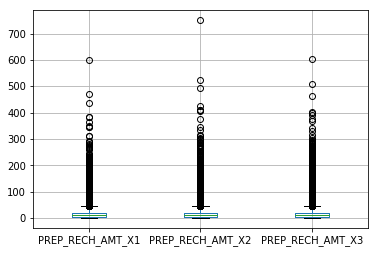

In [61]:
#vamos a comparar los montos de recargas acumuladas Mensuales - y despues comparamos cada una contra el target
fulldata.boxplot(['PREP_RECH_AMT_X1','PREP_RECH_AMT_X2','PREP_RECH_AMT_X3'])

Ahora vamos a hacer lo mismo con el TRAFICO DE DATOS DE OTRAS FUENTES MENSUALES

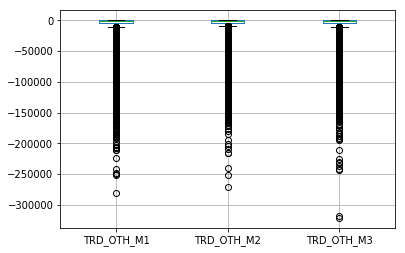

In [62]:
#vamos a comparar trafico de datos de otras fuentes mensual
fulldata.boxplot(['TRD_OTH_M1','TRD_OTH_M2','TRD_OTH_M3'])
#Los borramos porque estan inconsistentes

Eliminas las columnas TRAFICO DE DATOS DE OTRAS FUENTES MENSUALES porque como vimos en el 
grafico anterior son inconsistentes

In [63]:
#Eliminamos columnas con datos incorrectos
column_incorrect = ['TRD_OTH_M1',
                   'TRD_OTH_M2',
                   'TRD_OTH_M3']
fulldata.drop(columns=column_incorrect,inplace=True)

In [64]:
fulldata['TRS_ONNET_SMS_M1'].describe()

count    965133.000000
mean          0.174619
std           0.956142
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: TRS_ONNET_SMS_M1, dtype: float64

In [65]:
fulldata[fulldata.columns[:20]]

SUSCRIBER_KEY  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
0       E_67773005_20190427       9.41650     -82.52070     -82.52000   
1       E_65364767_20150701       8.58480     -82.38850     -81.82747   
2       E_67094312_20150701       8.79528     -80.14711     -79.65000   
3       E_66513730_20150701       9.08320     -79.59240     -79.47068   
4       E_67337458_20181130       9.08320     -79.59240     -79.51973   
5       E_65181285_20180422       8.58480     -82.38850     -82.42000   
6       E_68033218_20190224       9.08320     -79.59240     -79.51973   
7       E_66973254_20180923       8.65950     -81.77870     -81.85750   
8       E_67395190_20171101       8.62660     -80.36590     -80.35727   
9       E_67901068_20170509       8.62660     -80.36590     -80.35727   
10      E_67678847_20170305       9.08320     -79.59240     -79.10083   
11      E_67510158_20150701       9.08320     -79.59240     -79.51973   
12      E_67213118_20190617       8.58480     -82.38850     -82.54492   
13      E_69129806_20170603       8.58480     -82.38850     -82.43330   
14      E_67626024_20150602       9.08320     -79.59240     -79.51973   
15      E_63764117_20150701       8.58480     -82.38850     -82.61991   
16      E_67750901_20170923       8.58480     -82.38850     -82.43330   
17      E_67156321_20150701       9.08320     -79.59240     -79.47068   
18      E_69503488_20160530       9.08320     -79.59240     -79.51973   
19      E_67622839_20181225       9.08320     -79.59240     -79.47068   
20      E_66946667_20150701       8.58480     -82.38850     -82.43330   
21      E_69478724_20161015       9.18520     -80.05350     -79.90011   
22      E_63413816_20180110       8.62660     -80.36590     -80.35727   
23      E_67882549_20190515       8.79528     -80.14711     -79.65000   
24      E_67918889_20180320       8.79528     -80.14711     -79.78333   
25      E_69680799_20190518       8.12310     -81.07550     -80.84067   
26      E_65423800_20190322       8.79528     -80.14711     -79.78333   
27      E_67412057_20190617       8.58480     -82.38850     -82.43330   
28      E_68854346_20190107       9.08320     -79.59240     -79.47068   
29      E_67359095_20150702       8.79528     -80.14711     -79.65000   
...                     ...           ...           ...           ...   
967310  E_67292723_20160612       9.08320     -79.59240     -79.47068   
967311  E_69417644_20180303       8.79528     -80.14711     -79.65000   
967312  E_67771271_20170608       9.08320     -79.59240     -79.47068   
967313  E_67283298_20150701       9.08320     -79.59240     -79.51973   
967314  E_69670475_20190601       8.79528     -80.14711     -79.78333   
967315  E_66943341_20170325       7.59090     -80.36580     -80.44217   
967316  E_63779537_20150714       9.41650     -82.52070     -82.52000   
967317  E_68838816_20170703       8.58480     -82.38850     -82.57025   
967318  E_65241436_20190217       8.58480     -82.38850     -82.61991   
967319  E_65186296_20150702       8.62660     -80.36590     -80.35727   
967320  E_69109210_20160316       8.62660     -80.36590     -80.54609   
967321  E_67821983_20150602       9.08320     -79.59240     -79.51973   
967322  E_66897407_20150701       8.58480     -82.38850     -82.54492   
967323  E_67695495_20160614       9.08320     -79.59240     -79.10083   
967324  E_66877481_20150701       9.08320     -79.59240     -79.51973   
967325  E_66676757_20180518       8.79528     -80.14711     -79.78333   
967326  E_66883802_20160526       9.08320     -79.59240     -79.51973   
967327  E_63400870_20180609       9.08320     -79.59240     -79.51973   
967328  E_68768207_20190428       8.79528     -80.14711     -79.65000   
967329  E_65396445_20180406       9.18520     -80.05350     -79.90011   
967330  E_69663475_20151025       9.18520     -80.05350     -79.90011   
967331  E_69550816_20150701       9.08320     -79.59240     -79.51973   
967332  E_67759893_20181006       9.08320     -79.59240     -79.51973   

Vamos a trabajar ahora con la columna COMMERCIAL_ACTIVATION_DATE que nos informa la fecha de activacion de la linea 

In [66]:
#observa el tipo de dato de activation date y luego lo convierte a datetime- es tipo objeto
fulldata['COMMERCIAL_ACTIVATION_DATE'].dtype

dtype('O')

In [67]:
fulldata['COMMERCIAL_ACTIVATION_DATE']
#podemos ver que se representan las fechas como string 

0         27-APR-19
1         01-JUL-15
2         01-JUL-15
3         01-JUL-15
4         30-NOV-18
5         22-APR-18
6         24-FEB-19
7         23-SEP-18
8         01-NOV-17
9         09-MAY-17
10        05-MAR-17
11        01-JUL-15
12        17-JUN-19
13        03-JUN-17
14        02-JUN-15
15        01-JUL-15
16        23-SEP-17
17        01-JUL-15
18        30-MAY-16
19        25-DEC-18
20        01-JUL-15
21        15-OCT-16
22        10-JAN-18
23        15-MAY-19
24        20-MAR-18
25        18-MAY-19
26        22-MAR-19
27        17-JUN-19
28        07-JAN-19
29        02-JUL-15
            ...    
967310    12-JUN-16
967311    03-MAR-18
967312    08-JUN-17
967313    01-JUL-15
967314    01-JUN-19
967315    25-MAR-17
967316    14-JUL-15
967317    03-JUL-17
967318    17-FEB-19
967319    02-JUL-15
967320    16-MAR-16
967321    02-JUN-15
967322    01-JUL-15
967323    14-JUN-16
967324    01-JUL-15
967325    18-MAY-18
967326    26-MAY-16
967327    09-JUN-18
967328    28-APR-19


In [68]:
#entonces realizaremos una transformacion para tratarlas como data
fulldata['Date'] = pd.to_datetime(fulldata['COMMERCIAL_ACTIVATION_DATE'], format='%d-%b-%y')

In [69]:
#Tambien podemos obtener otros datos
fulldata['Dayofweek'] = fulldata['Date'].dt.dayofweek # obtenemos el dia de la semana (del 0 lunes al 6 domingo)
fulldata['Month'] = fulldata['Date'].dt.month # obtenemos el numero de mes
fulldata['Year'] = fulldata['Date'].dt.year # obtenemos el año
fulldata['Period'] = fulldata['Date'].dt.to_period('M') # obtenemos el periodo, en formato año/mes
fulldata.sort_values('Date', inplace=True) # ordenamos por fecha de activacion a los datos

In [70]:
#Veamos como quedaron nuestras nuevas columnas
fulldata[['COMMERCIAL_ACTIVATION_DATE', 'Date', 'Dayofweek', 'Month', 'Year', 'Period']]

COMMERCIAL_ACTIVATION_DATE       Date  Dayofweek  Month  Year   Period
517417                  25-MAY-11 2011-05-25          2      5  2011  2011-05
141845                  10-JUL-11 2011-07-10          6      7  2011  2011-07
938112                  10-JUL-11 2011-07-10          6      7  2011  2011-07
894538                  10-JUL-11 2011-07-10          6      7  2011  2011-07
238575                  04-SEP-11 2011-09-04          6      9  2011  2011-09
258013                  25-NOV-11 2011-11-25          4     11  2011  2011-11
658551                  25-NOV-11 2011-11-25          4     11  2011  2011-11
483039                  25-NOV-11 2011-11-25          4     11  2011  2011-11
821936                  22-APR-12 2012-04-22          6      4  2012  2012-04
396799                  22-APR-12 2012-04-22          6      4  2012  2012-04
645321                  22-APR-12 2012-04-22          6      4  2012  2012-04
773970                  22-APR-12 2012-04-22          6      4  2012  2012-04
524701                  22-APR-12 2012-04-22          6      4  2012  2012-04
369168                  22-APR-12 2012-04-22          6      4  2012  2012-04
310597                  22-APR-12 2012-04-22          6      4  2012  2012-04
605751                  22-APR-12 2012-04-22          6      4  2012  2012-04
662681                  22-APR-12 2012-04-22          6      4  2012  2012-04
772481                  22-APR-12 2012-04-22          6      4  2012  2012-04
204836                  12-MAY-12 2012-05-12          5      5  2012  2012-05
597241                  12-MAY-12 2012-05-12          5      5  2012  2012-05
362396                  12-MAY-12 2012-05-12          5      5  2012  2012-05
921955                  12-MAY-12 2012-05-12          5      5  2012  2012-05
423433                  12-MAY-12 2012-05-12          5      5  2012  2012-05
371852                  12-MAY-12 2012-05-12          5      5  2012  2012-05
442263                  12-MAY-12 2012-05-12          5      5  2012  2012-05
181876                  12-MAY-12 2012-05-12          5      5  2012  2012-05
518268                  12-MAY-12 2012-05-12          5      5  2012  2012-05
815729                  12-MAY-12 2012-05-12          5      5  2012  2012-05
597832                  12-MAY-12 2012-05-12          5      5  2012  2012-05
743513                  11-SEP-12 2012-09-11          1      9  2012  2012-09
...                           ...        ...        ...    ...   ...      ...
107676                  17-JUN-19 2019-06-17          0      6  2019  2019-06
941495                  17-JUN-19 2019-06-17          0      6  2019  2019-06
914672                  17-JUN-19 2019-06-17          0      6  2019  2019-06
403700                  17-JUN-19 2019-06-17          0      6  2019  2019-06
341343                  17-JUN-19 2019-06-17          0      6  2019  2019-06
403720                  17-JUN-19 2019-06-17          0      6  2019  2019-06
341482                  17-JUN-19 2019-06-17          0      6  2019  2019-06
107729                  17-JUN-19 2019-06-17          0      6  2019  2019-06
21209                   17-JUN-19 2019-06-17          0      6  2019  2019-06
186660                  17-JUN-19 2019-06-17          0      6  2019  2019-06
69181                   17-JUN-19 2019-06-17          0      6  2019  2019-06
654347                  17-JUN-19 2019-06-17          0      6  2019  2019-06
547754                  17-JUN-19 2019-06-17          0      6  2019  2019-06
153336                  17-JUN-19 2019-06-17          0      6  2019  2019-06
800749                  17-JUN-19 2019-06-17          0      6  2019  2019-06
737312                  17-JUN-19 2019-06-17          0      6  2019  2019-06
690394                  17-JUN-19 2019-06-17          0      6  2019  2019-06
737320                  17-JUN-19 2019-06-17          0      6  2019  2019-06
341813                  17-JUN-19 2019-06-17          0      6  2019  2019-06
690395                  17-JU

In [71]:
#Haremos uso de una tabla pivot para ver cuantos registros unicos existen para cada año
pd.pivot_table(data=fulldata,
               index=['Year'],
               aggfunc=['size']
              )

size
Year        
2011       8
2012      35
2013      76
2014     363
2015  317388
2016  112052
2017  129910
2018  212135
2019  193166

In [72]:
#Tambien podemos hacer una tabla pivot usando como indice el año y como columna los meses
pd.pivot_table(data=fulldata, 
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                          \
Month       1        2        3        4        5         6         7    
Year                                                                     
2011       NaN      NaN      NaN      NaN      1.0       NaN       3.0   
2012       NaN      NaN      NaN     10.0     11.0       NaN       NaN   
2013       NaN      NaN      NaN      NaN      5.0       NaN      71.0   
2014       NaN      NaN      NaN      NaN      NaN       NaN       NaN   
2015      48.0      NaN     39.0      NaN   7000.0  105550.0  168686.0   
2016    6977.0   6622.0   6699.0   7002.0  19812.0   12065.0    6951.0   
2017   10608.0   9779.0  10655.0   9015.0   9503.0   11188.0   10010.0   
2018   14046.0  11733.0  15552.0  14777.0  14001.0   15940.0   17834.0   
2019   28745.0  29130.0  34050.0  34428.0  39754.0   27059.0       NaN   

                                                    
Month       8        9        10       11       12  
Year                                                
2011       NaN      1.0      NaN      3.0      NaN  
2012       NaN     14.0      NaN      NaN      NaN  
2013       NaN      NaN      NaN      NaN      NaN  
2014       NaN      NaN      NaN    169.0    194.0  
2015    9707.0   5904.0   6074.0   5723.0   8657.0  
2016    7941.0   7723.0   8512.0   8024.0  13724.0  
2017   10519.0  10005.0  11510.0  10385.0  16733.0  
2018   18452.0  18084.0  19130.0  19865.0  32721.0  
2019       NaN      NaN      NaN      NaN      NaN

Observamos los resultados de la tabla pivot que son inconsistentes porque presentan periodos con valores nulos
y decidimos considerar que no pueden existir periodos con altas no consecutivas, entonces vamos a proceder a eliminar 
las filas que tengan una fecha de activacion menor a mayo del 2015 que es periodo a partir del cual no existen mas 
periodos nulos y hasta julio del 2019

In [73]:
period = pd.to_datetime('2015-05').to_period('M') 

In [74]:
fulldata = fulldata[fulldata['Period']>=period]

In [75]:
#veremos como quedo ahora la tabla sin los valores que eliminamos
pd.pivot_table(fulldata,
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                          \
Month       1        2        3        4        5         6         7    
Year                                                                     
2015       NaN      NaN      NaN      NaN   7000.0  105550.0  168686.0   
2016    6977.0   6622.0   6699.0   7002.0  19812.0   12065.0    6951.0   
2017   10608.0   9779.0  10655.0   9015.0   9503.0   11188.0   10010.0   
2018   14046.0  11733.0  15552.0  14777.0  14001.0   15940.0   17834.0   
2019   28745.0  29130.0  34050.0  34428.0  39754.0   27059.0       NaN   

                                                    
Month       8        9        10       11       12  
Year                                                
2015    9707.0   5904.0   6074.0   5723.0   8657.0  
2016    7941.0   7723.0   8512.0   8024.0  13724.0  
2017   10519.0  10005.0  11510.0  10385.0  16733.0  
2018   18452.0  18084.0  19130.0  19865.0  32721.0  
2019       NaN      NaN      NaN      NaN      NaN

In [76]:
#Podemos observar ahora que los meses de junio y julio representan valores mucho mas altos que la mayoria de los meses
#entonces asumimos que fue por alguna situacion atipica y decidimos eliminarlos tambien, dejando datos a partir de agosto
#del 2015
period = pd.to_datetime('2015-08').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]

In [77]:
#Observamos de nuevo como quedo la tabla
pd.pivot_table(fulldata,
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                                 \
Month       1        2        3        4        5        6        7        8    
Year                                                                            
2015       NaN      NaN      NaN      NaN      NaN      NaN      NaN   9707.0   
2016    6977.0   6622.0   6699.0   7002.0  19812.0  12065.0   6951.0   7941.0   
2017   10608.0   9779.0  10655.0   9015.0   9503.0  11188.0  10010.0  10519.0   
2018   14046.0  11733.0  15552.0  14777.0  14001.0  15940.0  17834.0  18452.0   
2019   28745.0  29130.0  34050.0  34428.0  39754.0  27059.0      NaN      NaN   

                                           
Month       9        10       11       12  
Year                                       
2015    5904.0   6074.0   5723.0   8657.0  
2016    7723.0   8512.0   8024.0  13724.0  
2017   10005.0  11510.0  10385.0  16733.0  
2018   18084.0  19130.0  19865.0  32721.0  
2019       NaN      NaN      NaN      NaN

In [78]:
#veremos cuantas filas tenemos ahora luego de los cambios realizados
fulldata.shape

(683328, 182)

In [79]:
#ahora vemos que en la tabla quedaron muchos valores nulos (los Nan) a estos los reemplazaremos por 0
#con el argumento fill_value
pivot_table = pd.pivot_table(fulldata,
                               index=['Year'],
                               columns=['Month'],
                               aggfunc=['size'],
                               fill_value=0 # le asignamos un valor a los nan
                              )
pivot_table

size                                                                 \
Month     1      2      3      4      5      6      7      8      9      10   
Year                                                                          
2015       0      0      0      0      0      0      0   9707   5904   6074   
2016    6977   6622   6699   7002  19812  12065   6951   7941   7723   8512   
2017   10608   9779  10655   9015   9503  11188  10010  10519  10005  11510   
2018   14046  11733  15552  14777  14001  15940  17834  18452  18084  19130   
2019   28745  29130  34050  34428  39754  27059      0      0      0      0   

                     
Month     11     12  
Year                 
2015    5723   8657  
2016    8024  13724  
2017   10385  16733  
2018   19865  32721  
2019       0      0

In [80]:
#vemos como nos queda nuestro data set luego de las respectivas transformaciones realizadas
fulldata.head()

SUSCRIBER_KEY  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
785510  E_66955652_20150801        8.6266      -80.3659     -80.44349   
337081  E_69646173_20150801        8.5848      -82.3885     -82.44136   
12721   E_68764817_20150801        9.0832      -79.5924     -79.51973   
205417  E_68452771_20150801        9.0832      -79.5924     -79.51973   
511138  E_63771745_20150801        9.0832      -79.5924     -79.51973   

        LON_CITY_BTS VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION  \
785510       8.59299    3 - SILVER         5-PV               PV1   
337081       8.78024    4 - BRONZE        7-LOW              LOW4   
12721        8.99360    3 - SILVER         2-PD               DO1   
205417       8.99360    4 - BRONZE        7-LOW              LOW2   
511138       8.99360      2 - GOLD         2-PD               DO3   

                      DEVICE_MODEL_NAME DEVICE_VENDOR_NAME  ...  \
785510                              L2Z              AZUMI  ...   
337081  GALAXY ACE NXT DUOS (SM-G313ML)            SAMSUNG  ...   
12721                P10 LITE (WAS-LX3)             HUAWEI  ...   
205417     GALAXY J2 DUOS (SM-J200M DS)            SAMSUNG  ...   
511138                Y5 2017 (MYA-L23)             HUAWEI  ...   

       PACK_DATA_EXP_W9 PACK_DATA_EXP_W10  PACK_DATA_EXP_W11  \
785510                0                 0                  0   
337081                0                 0                  0   
12721                 0                 0                  0   
205417                3                10                  0   
511138               14                 6                 13   

        PACK_DATA_EXP_W12  Target       Date  Dayofweek Month  Year   Period  
785510                  0       0 2015-08-01          5     8  2015  2015-08  
337081                  0       0 2015-08-01          5     8  2015  2015-08  
12721                   0       1 2015-08-01          5     8  2015  2015-08  
205417                  0       1 2015-08-01          5     8  2015  2015-08  
511138                  7       0 2015-08-01          5     8  2015  2015-08  

[5 rows x 182 columns]

## Checkpoint 2

In [81]:
fulldata.shape

(683328, 182)

In [82]:
fulldata.head()

SUSCRIBER_KEY  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
785510  E_66955652_20150801        8.6266      -80.3659     -80.44349   
337081  E_69646173_20150801        8.5848      -82.3885     -82.44136   
12721   E_68764817_20150801        9.0832      -79.5924     -79.51973   
205417  E_68452771_20150801        9.0832      -79.5924     -79.51973   
511138  E_63771745_20150801        9.0832      -79.5924     -79.51973   

        LON_CITY_BTS VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION  \
785510       8.59299    3 - SILVER         5-PV               PV1   
337081       8.78024    4 - BRONZE        7-LOW              LOW4   
12721        8.99360    3 - SILVER         2-PD               DO1   
205417       8.99360    4 - BRONZE        7-LOW              LOW2   
511138       8.99360      2 - GOLD         2-PD               DO3   

                      DEVICE_MODEL_NAME DEVICE_VENDOR_NAME  ...  \
785510                              L2Z              AZUMI  ...   
337081  GALAXY ACE NXT DUOS (SM-G313ML)            SAMSUNG  ...   
12721                P10 LITE (WAS-LX3)             HUAWEI  ...   
205417     GALAXY J2 DUOS (SM-J200M DS)            SAMSUNG  ...   
511138                Y5 2017 (MYA-L23)             HUAWEI  ...   

       PACK_DATA_EXP_W9 PACK_DATA_EXP_W10  PACK_DATA_EXP_W11  \
785510                0                 0                  0   
337081                0                 0                  0   
12721                 0                 0                  0   
205417                3                10                  0   
511138               14                 6                 13   

        PACK_DATA_EXP_W12  Target       Date  Dayofweek Month  Year   Period  
785510                  0       0 2015-08-01          5     8  2015  2015-08  
337081                  0       0 2015-08-01          5     8  2015  2015-08  
12721                   0       1 2015-08-01          5     8  2015  2015-08  
205417                  0       1 2015-08-01          5     8  2015  2015-08  
511138                  7       0 2015-08-01          5     8  2015  2015-08  

[5 rows x 182 columns]

## Distribución del Dataset

### Univariadas

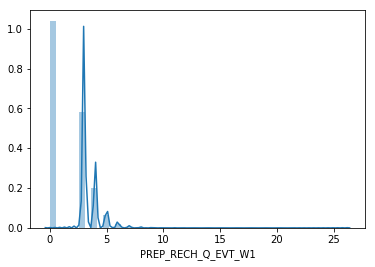

In [83]:
#veremos en un grafico la cantidad de recargas acumuladas mensuales en el mes 1 
sns.distplot(fulldata['PREP_RECH_Q_EVT_W1'])

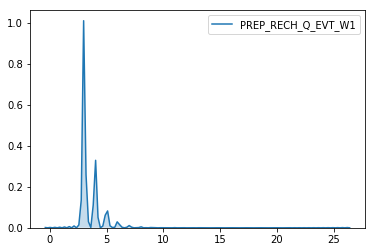

In [84]:
sns.kdeplot(fulldata['PREP_RECH_Q_EVT_W1'],shade=True)

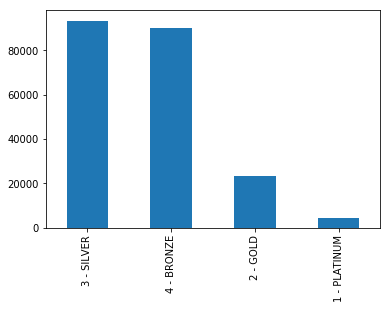

In [85]:
#comparo el target de los que se van con el value segment 
fulldata[fulldata['Target']==1]['VALUE_SEGMENT'].value_counts().plot.bar()

In [86]:
#sumamos los full data y luego borramos las columnas de PACK_DATA_EXP_Wi
#fulldata['TOTAL_EXP_PACKDATA_W'] = fulldata[fulldata.columns[178:188]].sum(axis=1)
#elimino lo que ya sume
#fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_EXP_W' in x],inplace=True)
#fulldata['TOTAL_EXP_PACKDATA_W']=fulldata['TOTAL_EXP_PACKDATA_W']<1
#fulldata['TOTAL_EXP_PACKDATA_W'] = fulldata['TOTAL_EXP_PACKDATA_W'].astype(int)

In [87]:
fulldata.columns.to_list()

['SUSCRIBER_KEY',
 'LAT_PROV_BTS',
 'LON_PROV_BTS',
 'LAT_CITY_BTS',
 'LON_CITY_BTS',
 'VALUE_SEGMENT',
 'SEGMENTATION',
 'MICROSEGMENTATION',
 'DEVICE_MODEL_NAME',
 'DEVICE_VENDOR_NAME',
 'NETWORK_TECH',
 'COMMERCIAL_ACTIVATION_DATE',
 'TENURE_CUSTOMER',
 'TENURE_CUSTOMER_BL',
 'PREP_RECH_AMT_X1',
 'PREP_RECH_AMT_X2',
 'PREP_RECH_AMT_X3',
 'PREP_RECH_LAST_DAY_12W',
 'PREP_RECH_NDAYS_LASTRECH_12W',
 'PREP_RECH_CHNNL_MODE12W',
 'PREP_RECH_Q_EVT_W1',
 'PREP_RECH_Q_EVT_W2',
 'PREP_RECH_Q_EVT_W3',
 'PREP_RECH_Q_EVT_W4',
 'PREP_RECH_Q_EVT_W5',
 'PREP_RECH_Q_EVT_W6',
 'PREP_RECH_Q_EVT_W7',
 'PREP_RECH_Q_EVT_W8',
 'PREP_RECH_Q_EVT_W9',
 'PREP_RECH_Q_EVT_W10',
 'PREP_RECH_Q_EVT_W11',
 'PREP_RECH_Q_EVT_W12',
 'PREP_RECH_AMT_W1',
 'PREP_RECH_AMT_W2',
 'PREP_RECH_AMT_W3',
 'PREP_RECH_AMT_W4',
 'PREP_RECH_AMT_W5',
 'PREP_RECH_AMT_W6',
 'PREP_RECH_AMT_W7',
 'PREP_RECH_AMT_W8',
 'PREP_RECH_AMT_W9',
 'PREP_RECH_AMT_W10',
 'PREP_RECH_AMT_W11',
 'PREP_RECH_AMT_W12',
 'TRD_M1',
 'TRD_M2',
 'TRD_M3',
 'T

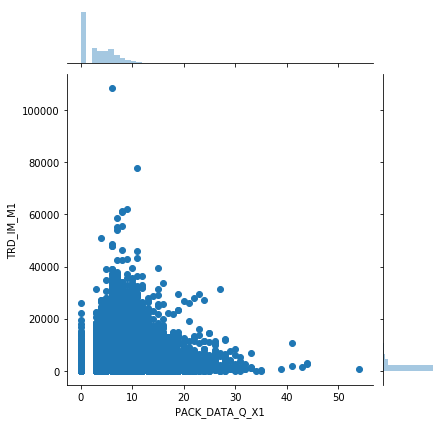

In [88]:
#grafico donde relacionamos la cantidad de pack de datos mensuales con el trafico de datos de mensaje por internet 
#mensual, en el mes 1
sns.jointplot(x=fulldata['PACK_DATA_Q_X1'], y=fulldata['TRD_IM_M1'])

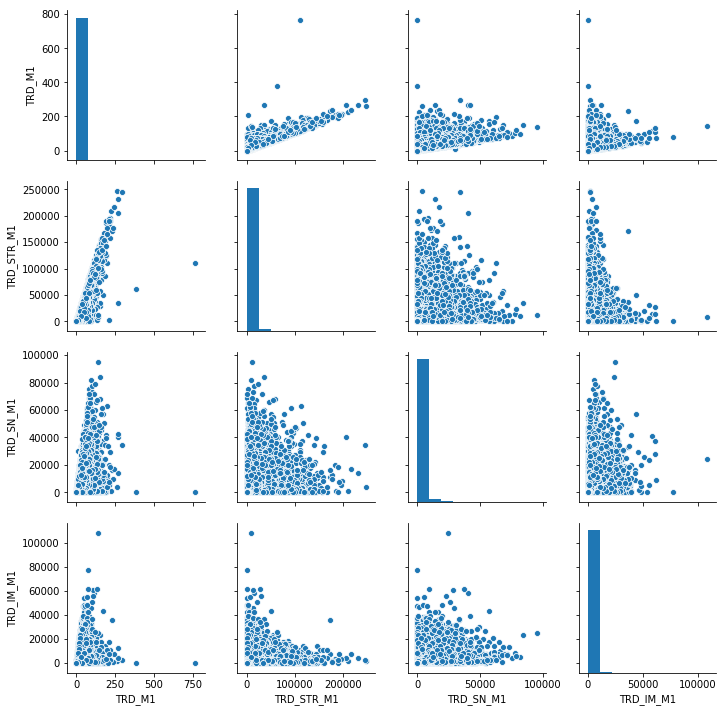

In [89]:
#TRD_M1 = trafico de datos mensual
#TRD_STR_M1 = trafico de datos en streaming mensual
#TRD_SN_M1 = trafico de datos en redes sociales mensual
#TRD_IM_M1 = trafico de datos de mensajes por internet mensual

sns.pairplot(fulldata[['TRD_M1','TRD_STR_M1','TRD_SN_M1','TRD_IM_M1']])

(683328, 182)

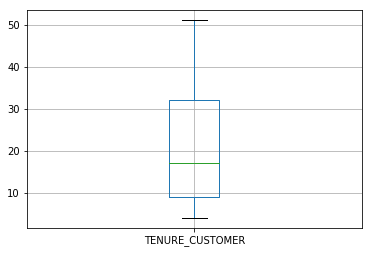

In [90]:
#Analizamos la variable TERNURE_CUSTOMER
fulldata.boxplot(['TENURE_CUSTOMER']) 
fulldata.shape

(683328, 182)

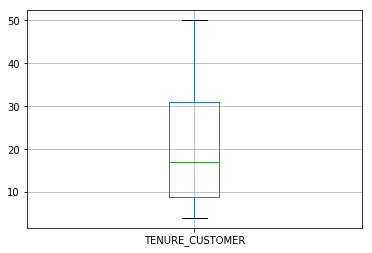

In [91]:
#Vemos como queda el grafico si eliminariamos valores muy extremos
fulldata[fulldata['TENURE_CUSTOMER']<=fulldata['TENURE_CUSTOMER'].quantile(0.99)].boxplot('TENURE_CUSTOMER')
fulldata.shape

In [92]:
fulldata.loc[fulldata['TENURE_CUSTOMER']>fulldata['TENURE_CUSTOMER'].quantile(0.99),'TENURE_CUSTOMER']=fulldata['TENURE_CUSTOMER'].quantile(0.99)

(683328, 182)

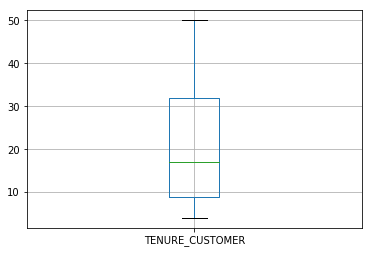

In [93]:
fulldata.boxplot(['TENURE_CUSTOMER'])
fulldata.shape

In [94]:
#Comparo Antiguedad contra el target 0 y 1
Tenure_1 = fulldata[fulldata["Target"] == 1]["TENURE_CUSTOMER"].value_counts(normalize=True).sort_index()
Tenure_0 = fulldata[fulldata["Target"] == 0]["TENURE_CUSTOMER"].value_counts(normalize=True).sort_index()
#fulldata[fulldata['SUSCRIBER_KEY']=='E_68006527_20110525']["TENURE_CUSTOMER"] 

In [95]:
#ind=np.arange(fulldata['TENURE_CUSTOMER'].nunique()) 
#width = 0.40  # ancho de las barras

fig = go.Figure(data=[
    go.Bar(name='Target1- Se va',y=Tenure_1.values,x=Tenure_1.index),
    go.Bar(name='Target0- Se queda',y=Tenure_0.values,x=Tenure_0.index)
])
# Change the bar mode
fig.update_layout(xaxis=dict(range=[0,60]))
fig.update_layout(barmode='group')


fig.update_layout(
    title="Comparasion Targets con Tenure Customer",
    xaxis_title="Antiguedad cliente",
    yaxis_title="Fr. Relativa",

)

fig.show()

(683328, 182)

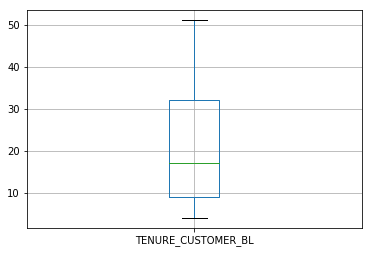

In [96]:
#Analizamos la variable TERNURE_CUSTOMER_BL- Antiguedad desde el primer gasto
fulldata.boxplot(['TENURE_CUSTOMER_BL']) 
fulldata.shape

In [97]:
#Comparo Antiguedad contra el target 0 y 1
TenureBL_1 = fulldata[fulldata["Target"] == 1]["TENURE_CUSTOMER_BL"].value_counts(normalize=True).sort_index()
TenureBL_0 = fulldata[fulldata["Target"] == 0]["TENURE_CUSTOMER_BL"].value_counts(normalize=True).sort_index()

In [98]:
#ind=np.arange(fulldata['TENURE_CUSTOMER'].nunique()) 
#width = 0.40  # ancho de las barras

fig = go.Figure(data=[
    go.Bar(name='Target1- Se va',y=TenureBL_1.values,x=TenureBL_1.index),
    go.Bar(name='Target0- Se queda',y=TenureBL_0.values,x=TenureBL_0.index)
])
# Change the bar mode
fig.update_layout(xaxis=dict(range=[0,60]))
fig.update_layout(barmode='group')


fig.update_layout(
    title="Comparasion Targets con Antiguedad desde que hizo el primer gasto",
    xaxis_title="Antiguedad desde que hizo el primer gasto",
    yaxis_title="Fr. Relativa",

)

fig.show()

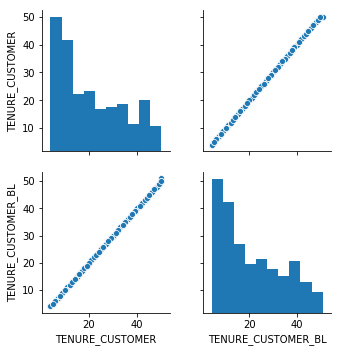

In [99]:
#Comparasion entre  TENURE_CUSTOMER y  TENURE_CUSTOMER_BL SON IGUALES LA ELIMINO A TERNURE_COSTUMER_BL

for_pairplot= fulldata[["TENURE_CUSTOMER", "TENURE_CUSTOMER_BL"]]
for_pairplot=for_pairplot.sample(1000)
sns.pairplot(for_pairplot)

In [100]:
#Borro la columna TENURE_CUSTOMER_BL
fulldata.drop(columns="TENURE_CUSTOMER_BL", inplace=True)

Comparacion entre Montos pack voz mensual y Cantidad de pack voz mensual  PACK_VOICE_Q_X1 PACK_VOICE_Q_X2 PACK_VOICE_Q_X3 PACK_VOICE_AMT_X1 PACK_VOICE_AMT_X2 PACK_VOICE_AMT_X3 







Text(0.5, 1, 'Montos Pack voz mensual y Cantidad de pack voz mensual \nCorrelation Heatmap')

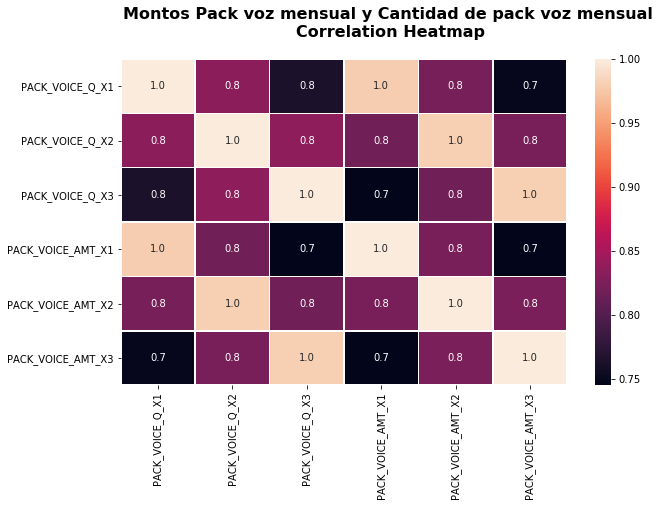

In [101]:
#Comparacion entre Montos pack voz mensual y Cantidad de pack voz mensual  PACK_VOICE_Q_X1 PACK_VOICE_Q_X2 PACK_VOICE_Q_X3 PACK_VOICE_AMT_X1 PACK_VOICE_AMT_X2 PACK_VOICE_AMT_X3
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(fulldata[["PACK_VOICE_Q_X1", "PACK_VOICE_Q_X2", "PACK_VOICE_Q_X3", "PACK_VOICE_AMT_X1",
                     "PACK_VOICE_AMT_X2", "PACK_VOICE_AMT_X3"]].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Montos Pack voz mensual y Cantidad de pack voz mensual \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)


In [102]:
# Vemos que tienen una alta correlacion elimino las los montos
fulldata.drop(columns=['PACK_VOICE_AMT_X1','PACK_VOICE_AMT_X1','PACK_VOICE_AMT_X1'], inplace=True)

Comparacion entre Montos pack datos mensual y Cantidad de pack datos mensual  PACK_DATA_Q_X1 PACK_DATA_Q_X2 PACK_DATA_Q_X3  PACK_VOICE_AMT_X1  PACK_VOICE_AMT_X2  PACK_VOICE_AMT_X3

Text(0.5, 1, 'Montos Pack datos mensual y Cantidad de pack datos mensual \nCorrelation Heatmap')

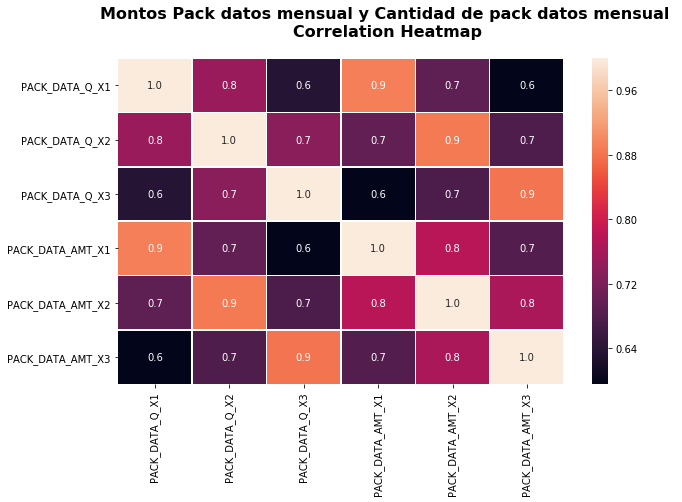

In [103]:
#Comparacion entre Montos pack voz mensual y Cantidad de pack voz mensual  PACK_DATA_Q_X1 PACK_DATA_Q_X2 PACK_DATA_Q_X3 PACK_DATA_AMT_X1 PACK_DATA_AMT_X2 PACK_DATA_AMT_X3

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(fulldata[["PACK_DATA_Q_X1", "PACK_DATA_Q_X2", "PACK_DATA_Q_X3", "PACK_DATA_AMT_X1",
                     "PACK_DATA_AMT_X2", "PACK_DATA_AMT_X3"]].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Montos Pack datos mensual y Cantidad de pack datos mensual \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)


In [104]:
# Vemos que tienen una alta correlacion elimino las los montos
fulldata.drop(columns=['PACK_DATA_AMT_X1','PACK_DATA_AMT_X2','PACK_DATA_AMT_X3'], inplace=True)


Comparacion entre Montos pack datos mensual y Cantidad de pack datos mensual  PACK_SMS_Q_X1  PACK_SMS_Q_X2  PACK_SMS_Q_X3  PACK_SMS_AMT_X1  PACK_SMS_AMT_X2  PACK_SMS_AMT_X3 

Text(0.5, 1, 'Montos Pack SMS mensual y Cantidad de pack SMS mensual \nCorrelation Heatmap')

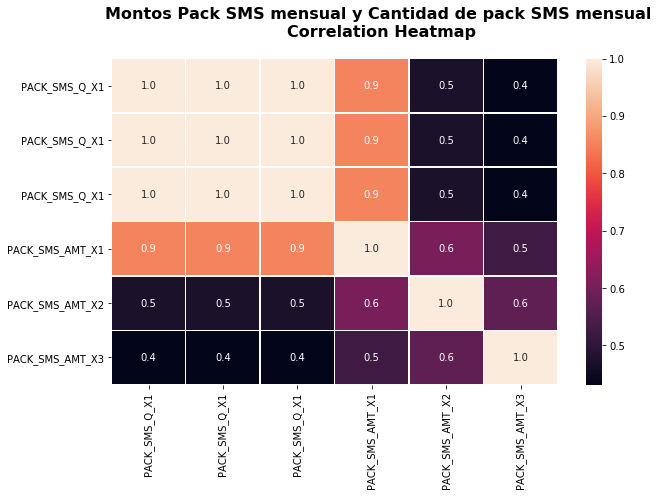

In [105]:
#Comparacion entre Montos pack mensual y Cantidad de pack SMS  PACK_SMS_Q_X1 PACK_SMS_Q_X2 PACK_SMS_Q_X3 PACK_SMS_AMT_X1 PACK_SMS_AMT_X2 PACK_SMS_AMT_X3

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(fulldata[["PACK_SMS_Q_X1", "PACK_SMS_Q_X1", "PACK_SMS_Q_X1", "PACK_SMS_AMT_X1",
                     "PACK_SMS_AMT_X2", "PACK_SMS_AMT_X3"]].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Montos Pack SMS mensual y Cantidad de pack SMS mensual \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)


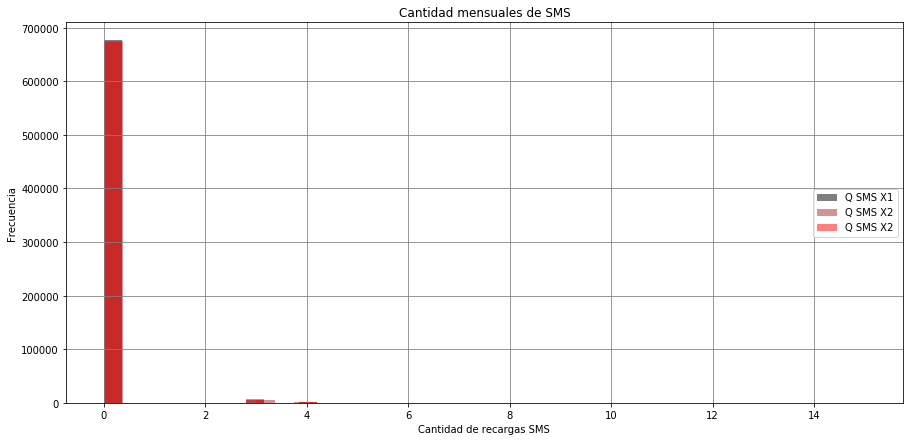

In [106]:
# Vemos que tienen una alta correlacion elimino las los montos
#fulldata.drop(columns=['PACK_DATA_AMT_X1','PACK_DATA_AMT_X2','PACK_DATA_AMT_X3'], inplace=True)
#no tiene valores borro todo 
plt.figure(figsize=(15,7));

plt.hist(fulldata["PACK_SMS_Q_X1"], bins=40, alpha=0.5, label='Q SMS X1', color = "black") 
plt.hist(fulldata["PACK_SMS_Q_X2"], bins=40, alpha=0.5, label='Q SMS X2', color = "brown") 
plt.hist(fulldata["PACK_SMS_Q_X3"], bins=40, alpha=0.5, label='Q SMS X2', color = "red") ;

plt.title('Cantidad mensuales de SMS');

plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de recargas SMS');
plt.legend(loc="center right")
plt.grid(color='grey', linestyle='solid');

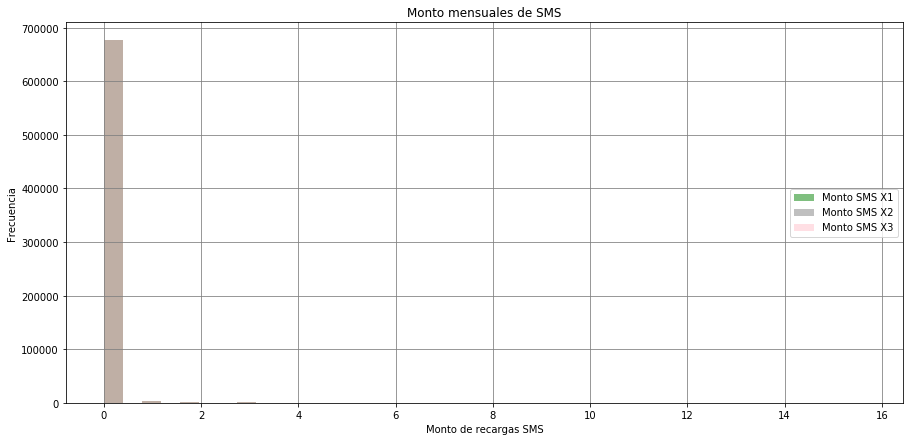

In [107]:
plt.figure(figsize=(15,7));

plt.hist(fulldata["PACK_SMS_AMT_X1"], bins=40, alpha=0.5, label='Monto SMS X1', color = "green") 
plt.hist(fulldata["PACK_SMS_AMT_X1"], bins=40, alpha=0.5, label='Monto SMS X2', color = "grey") 
plt.hist(fulldata["PACK_SMS_AMT_X1"], bins=40, alpha=0.5, label='Monto SMS X3', color = "pink");

plt.title('Monto mensuales de SMS');
plt.ylabel('Frecuencia')
plt.xlabel('Monto de recargas SMS');
plt.legend(loc="center right")
plt.grid(color='grey', linestyle='solid');

In [108]:
# No tiene valores borro esas columnas 
fulldata.drop(columns=['PACK_SMS_Q_X1','PACK_SMS_Q_X2','PACK_SMS_Q_X3','PACK_SMS_AMT_X1','PACK_SMS_AMT_X2','PACK_SMS_AMT_X3'], inplace=True)


In [109]:
 #fulldata['TRS_ONNET_SMS_M1'].describe()
(fulldata[[x for x in fulldata.columns if 'SMS' in x]]==0).sum()/fulldata.shape[0]

TRS_ONNET_SMS_M1     0.954647
TRS_ONNET_SMS_M2     0.950955
TRS_ONNET_SMS_M3     0.948752
TRS_OFFNET_SMS_M1    0.793824
TRS_OFFNET_SMS_M2    0.795662
TRS_OFFNET_SMS_M3    0.800462
PACK_SMS_Q_W1        0.996892
PACK_SMS_Q_W2        0.996716
PACK_SMS_Q_W3        0.996693
PACK_SMS_Q_W4        0.996464
PACK_SMS_Q_W5        0.996543
PACK_SMS_Q_W6        0.996248
PACK_SMS_Q_W7        0.996426
PACK_SMS_Q_W8        0.995910
PACK_SMS_Q_W9        0.996049
PACK_SMS_Q_W10       0.995910
PACK_SMS_Q_W11       0.995381
PACK_SMS_Q_W12       0.995115
PACK_SMS_AMT_W1      0.996892
PACK_SMS_AMT_W2      0.996716
PACK_SMS_AMT_W3      0.996693
PACK_SMS_AMT_W4      0.996464
PACK_SMS_AMT_W5      0.996543
PACK_SMS_AMT_W6      0.996248
PACK_SMS_AMT_W7      0.996426
PACK_SMS_AMT_W8      0.995910
PACK_SMS_AMT_W9      0.996049
PACK_SMS_AMT_W10     0.995910
PACK_SMS_AMT_W11     0.995381
PACK_SMS_AMT_W12     0.995115
dtype: float64

## Checkpoint 3

In [110]:
fulldata.shape

(683328, 171)

In [111]:
fulldata.head()

SUSCRIBER_KEY  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
785510  E_66955652_20150801        8.6266      -80.3659     -80.44349   
337081  E_69646173_20150801        8.5848      -82.3885     -82.44136   
12721   E_68764817_20150801        9.0832      -79.5924     -79.51973   
205417  E_68452771_20150801        9.0832      -79.5924     -79.51973   
511138  E_63771745_20150801        9.0832      -79.5924     -79.51973   

        LON_CITY_BTS VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION  \
785510       8.59299    3 - SILVER         5-PV               PV1   
337081       8.78024    4 - BRONZE        7-LOW              LOW4   
12721        8.99360    3 - SILVER         2-PD               DO1   
205417       8.99360    4 - BRONZE        7-LOW              LOW2   
511138       8.99360      2 - GOLD         2-PD               DO3   

                      DEVICE_MODEL_NAME DEVICE_VENDOR_NAME  ...  \
785510                              L2Z              AZUMI  ...   
337081  GALAXY ACE NXT DUOS (SM-G313ML)            SAMSUNG  ...   
12721                P10 LITE (WAS-LX3)             HUAWEI  ...   
205417     GALAXY J2 DUOS (SM-J200M DS)            SAMSUNG  ...   
511138                Y5 2017 (MYA-L23)             HUAWEI  ...   

       PACK_DATA_EXP_W9 PACK_DATA_EXP_W10  PACK_DATA_EXP_W11  \
785510                0                 0                  0   
337081                0                 0                  0   
12721                 0                 0                  0   
205417                3                10                  0   
511138               14                 6                 13   

        PACK_DATA_EXP_W12  Target       Date Dayofweek  Month  Year   Period  
785510                  0       0 2015-08-01         5      8  2015  2015-08  
337081                  0       0 2015-08-01         5      8  2015  2015-08  
12721                   0       1 2015-08-01         5      8  2015  2015-08  
205417                  0       1 2015-08-01         5      8  2015  2015-08  
511138                  7       0 2015-08-01         5      8  2015  2015-08  

[5 rows x 171 columns]

## Analisis datos SMS 

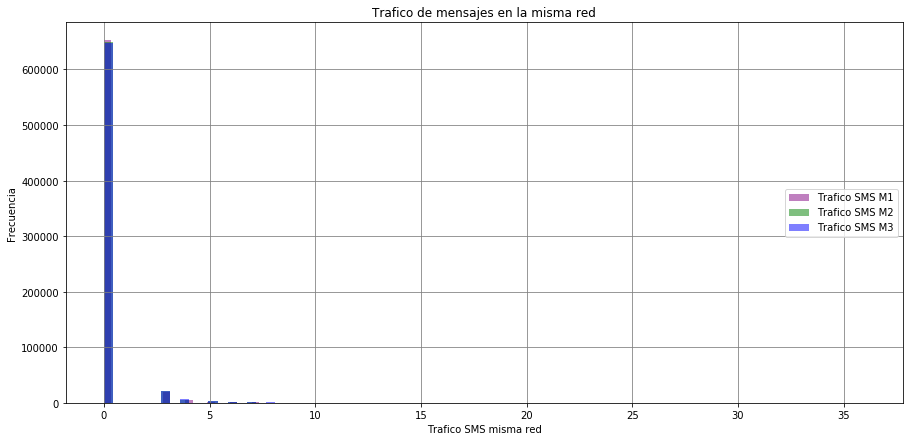

In [112]:
#Trafico de SMS en la misma red
plt.figure(figsize=(15,7))
plt.hist(fulldata['TRS_ONNET_SMS_M1'], bins=80, alpha=0.5, label='Trafico SMS M1', color = "purple");
plt.hist(fulldata['TRS_ONNET_SMS_M2'], bins=80, alpha=0.5, label='Trafico SMS M2', color = "green");
plt.hist(fulldata['TRS_ONNET_SMS_M3'], bins=80, alpha=0.5, label='Trafico SMS M3', color = "blue");
plt.title('Trafico de mensajes en la misma red');
plt.ylabel('Frecuencia')
plt.xlabel('Trafico SMS misma red');
plt.legend(loc="center right")
plt.grid(color='grey', linestyle='solid');

In [113]:
#Como son muy cercanos a 0 - borro estos campos TRS_ONNET_SMS_M1 TRS_ONNET_SMS_M2 TRS_ONNET_SMS_M3
fulldata.drop(columns=['TRS_ONNET_SMS_M1','TRS_ONNET_SMS_M2','TRS_ONNET_SMS_M3'], inplace=True)

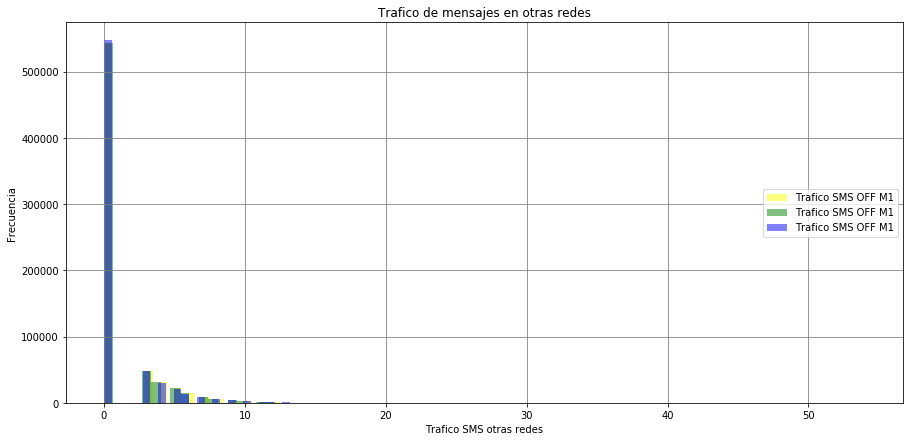

In [114]:
#Trafico de mensajes en otras redes
plt.figure(figsize=(15,7))
plt.hist(fulldata['TRS_OFFNET_SMS_M1'], bins=80, alpha=0.5, label='Trafico SMS OFF M1', color = "yellow");
plt.hist(fulldata['TRS_OFFNET_SMS_M2'], bins=80, alpha=0.5, label='Trafico SMS OFF M1', color = "green");
plt.hist(fulldata['TRS_OFFNET_SMS_M3'], bins=80, alpha=0.5, label='Trafico SMS OFF M1', color = "blue");
plt.title('Trafico de mensajes en otras redes');
plt.ylabel('Frecuencia')
plt.xlabel('Trafico SMS otras redes');
plt.legend(loc="center right")
plt.grid(color='grey', linestyle='solid');


In [115]:
#Como son muy cercanos a 0 - borro estos campos TRS_OFFNET_SMS_M1 TRS_OFFNET_SMS_M2 TRS_OFFNET_SMS_M3
fulldata.drop(columns=['TRS_OFFNET_SMS_M1','TRS_OFFNET_SMS_M2','TRS_OFFNET_SMS_M3'], inplace=True)

In [116]:
fulldata[['TRD_M1','TRD_STR_M1','TRD_SN_M1','TRD_IM_M1']].head()

TRD_M1  TRD_STR_M1  TRD_SN_M1  TRD_IM_M1
785510    0.00           0          0          0
337081    0.00           0          0          0
12721     6.84         725       2160       1404
205417    0.00           0          0          0
511138    6.19        1791       1555       1231

In [117]:
fulldata[['TRD_STR_M1','TRD_SN_M1','TRD_IM_M1']].div(1024).sum(axis=1)

785510     0.000000
337081     0.000000
12721      4.188477
205417     0.000000
511138     4.469727
108679     3.070312
172389    31.526367
339455     0.000000
140674     0.000000
78923      0.014648
574676     4.836914
221168     0.000000
666766     0.482422
596471     0.282227
340562     0.000000
724426     4.011719
841695     0.000000
90705      2.729492
648009    25.334961
167374     0.000000
518148    10.427734
707588     6.270508
752884     0.000000
476449     0.000000
86505      0.172852
478608     0.000000
395954     0.000000
741916     0.285156
745329     0.995117
333721     0.000000
            ...    
107676     0.000000
941495     2.676758
914672     0.000000
403700     0.000000
341343     0.063477
403720     7.125000
341482    36.509766
107729     0.000000
21209     16.681641
186660     0.000000
69181      0.000000
654347     0.000000
547754     3.375000
153336     3.418945
800749     0.002930
737312     0.000000
690394     0.000000
737320     3.631836
341813     0.000000


## Checkpoint 4

In [118]:
fulldata.shape

(683328, 165)

In [119]:
fulldata.head()

SUSCRIBER_KEY  LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  \
785510  E_66955652_20150801        8.6266      -80.3659     -80.44349   
337081  E_69646173_20150801        8.5848      -82.3885     -82.44136   
12721   E_68764817_20150801        9.0832      -79.5924     -79.51973   
205417  E_68452771_20150801        9.0832      -79.5924     -79.51973   
511138  E_63771745_20150801        9.0832      -79.5924     -79.51973   

        LON_CITY_BTS VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION  \
785510       8.59299    3 - SILVER         5-PV               PV1   
337081       8.78024    4 - BRONZE        7-LOW              LOW4   
12721        8.99360    3 - SILVER         2-PD               DO1   
205417       8.99360    4 - BRONZE        7-LOW              LOW2   
511138       8.99360      2 - GOLD         2-PD               DO3   

                      DEVICE_MODEL_NAME DEVICE_VENDOR_NAME  ...  \
785510                              L2Z              AZUMI  ...   
337081  GALAXY ACE NXT DUOS (SM-G313ML)            SAMSUNG  ...   
12721                P10 LITE (WAS-LX3)             HUAWEI  ...   
205417     GALAXY J2 DUOS (SM-J200M DS)            SAMSUNG  ...   
511138                Y5 2017 (MYA-L23)             HUAWEI  ...   

       PACK_DATA_EXP_W9 PACK_DATA_EXP_W10  PACK_DATA_EXP_W11  \
785510                0                 0                  0   
337081                0                 0                  0   
12721                 0                 0                  0   
205417                3                10                  0   
511138               14                 6                 13   

        PACK_DATA_EXP_W12  Target       Date Dayofweek  Month  Year   Period  
785510                  0       0 2015-08-01         5      8  2015  2015-08  
337081                  0       0 2015-08-01         5      8  2015  2015-08  
12721                   0       1 2015-08-01         5      8  2015  2015-08  
205417                  0       1 2015-08-01         5      8  2015  2015-08  
511138                  7       0 2015-08-01         5      8  2015  2015-08  

[5 rows x 165 columns]

### Binarizacion de variables categoricas

Vamos a convertir en variables binarias a algunas variables categóricas que podrían aportar valor al modelo, como por ejemplo las categorías de segmentación y microsegmentación de clientes, para luego poder calcular correlciones con el target.

In [120]:
#creamos un data frame que solo contiene las variables numericas
df_numeric = fulldata.select_dtypes('number')
columns_num=df_numeric.columns
columns_num


Index(['LAT_PROV_BTS', 'LON_PROV_BTS', 'LAT_CITY_BTS', 'LON_CITY_BTS',
       'TENURE_CUSTOMER', 'PREP_RECH_AMT_X1', 'PREP_RECH_AMT_X2',
       'PREP_RECH_AMT_X3', 'PREP_RECH_NDAYS_LASTRECH_12W',
       'PREP_RECH_Q_EVT_W1',
       ...
       'PACK_DATA_EXP_W7', 'PACK_DATA_EXP_W8', 'PACK_DATA_EXP_W9',
       'PACK_DATA_EXP_W10', 'PACK_DATA_EXP_W11', 'PACK_DATA_EXP_W12', 'Target',
       'Dayofweek', 'Month', 'Year'],
      dtype='object', length=153)

In [121]:
columns_cat = [col for col in fulldata.columns if col not in columns_num]
columns_cat

['SUSCRIBER_KEY',
 'VALUE_SEGMENT',
 'SEGMENTATION',
 'MICROSEGMENTATION',
 'DEVICE_MODEL_NAME',
 'DEVICE_VENDOR_NAME',
 'NETWORK_TECH',
 'COMMERCIAL_ACTIVATION_DATE',
 'PREP_RECH_LAST_DAY_12W',
 'PREP_RECH_CHNNL_MODE12W',
 'Date',
 'Period']

In [122]:
df_categoric=fulldata[columns_cat]
df_categoric

SUSCRIBER_KEY VALUE_SEGMENT SEGMENTATION MICROSEGMENTATION  \
785510  E_66955652_20150801    3 - SILVER         5-PV               PV1   
337081  E_69646173_20150801    4 - BRONZE        7-LOW              LOW4   
12721   E_68764817_20150801    3 - SILVER         2-PD               DO1   
205417  E_68452771_20150801    4 - BRONZE        7-LOW              LOW2   
511138  E_63771745_20150801      2 - GOLD         2-PD               DO3   
108679  E_68048906_20150801      2 - GOLD         4-VD              HCV1   
172389  E_66887178_20150801      2 - GOLD         2-PD               PD3   
339455  E_68063587_20150801    4 - BRONZE        7-LOW              LOW3   
140674  E_68726984_20150801    3 - SILVER         6-OH               OH2   
78923   E_66636198_20150801    3 - SILVER        7-LOW              LOW4   
574676  E_68719144_20150801      2 - GOLD        1-HCV              HCV2   
221168  E_66684129_20150801    3 - SILVER         6-OH               OH3   
666766  E_69191643_20150801    3 - SILVER         6-OH              LOW2   
596471  E_69167578_20150801      2 - GOLD         6-OH               OH4   
340562  E_65127508_20150801    3 - SILVER        7-LOW              LOW4   
724426  E_65402269_20150801      2 - GOLD         4-VD              HCV1   
841695  E_67871272_20150801    4 - BRONZE        7-LOW              LOW3   
90705   E_69928713_20150801    3 - SILVER         3-DO               DO3   
648009  E_67137346_20150801  1 - PLATINUM        1-HCV              HCV4   
167374  E_69937987_20150801  1 - PLATINUM         5-PV               PV1   
518148  E_67740261_20150801  1 - PLATINUM         2-PD               PD3   
707588  E_67153196_20150801      2 - GOLD        1-HCV               VD1   
752884  E_68819227_20150801    3 - SILVER        7-LOW              LOW3   
476449  E_69495258_20150801    3 - SILVER        7-LOW              LOW3   
86505   E_67641448_20150801      2 - GOLD         3-DO               OH3   
478608  E_67544769_20150801    3 - SILVER        7-LOW               DO1   
395954  E_68790206_20150801    4 - BRONZE        7-LOW               OH4   
741916  E_63461036_20150801      2 - GOLD         6-OH               OH4   
745329  E_67661558_20150801    3 - SILVER         5-PV               VD2   
333721  E_65192276_20150801  1 - PLATINUM         5-PV               PV1   
...                     ...           ...          ...               ...   
107676  E_67879840_20190617    4 - BRONZE        7-LOW              LOW3   
941495  E_68784345_20190617  1 - PLATINUM        1-HCV              HCV1   
914672  E_69455331_20190617    4 - BRONZE        7-LOW              LOW4   
403700  E_65342250_20190617    4 - BRONZE        7-LOW              LOW4   
341343  E_67292881_20190617    3 - SILVER         6-OH               OH4   
403720  E_67155929_20190617      2 - GOLD         2-PD               PD1   
341482  E_69016003_20190617      2 - GOLD        1-HCV              HCV4   
107729  E_69698431_20190617    3 - SILVER         6-OH               OH3   
21209   E_69199279_20190617  1 - PLATINUM        1-HCV               PD2   
186660  E_68840847_20190617    4 - BRONZE        7-LOW              LOW4   
69181   E_63708047_20190617    4 - BRONZE        7-LOW               DO1   
654347  E_68824548_20190617    4 - BRONZE        7-LOW              LOW3   
547754  E_69117708_20190617      2 - GOLD         3-DO               DO3   
153336  E_65537477_20190617      2 - GOLD         4-VD              HCV1   
800749  E_68455475_20190617    4 - BRONZE        7-LOW              LOW4   
737312  E_67243730_20190617    4 - BRONZE        7-LOW              LOW4   
690394  E_66544130_20190617    3 - SILVER        7-LOW               DO1   
737320  E_63427765_20190617    3 - SILVER         3-DO               PD1   
341813  E_66938629_20190617    3 - SILVER         5-PV               PV1   
690395  E_65514323_20190617      2 - GOLD         2-PD               PD1   
107461  E_67866756_20190617  1 - PLATINUM        1-HCV        

In [123]:
#Analizamos que variables podrian ser binarizadas segun la cantidad de valores unicos que posean, de manera de no necesitar demasiadas columnas extras
for i in columns_cat:
    print(i,":",df_categoric[i].unique())

SUSCRIBER_KEY : ['E_66955652_20150801' 'E_69646173_20150801' 'E_68764817_20150801' ...
 'E_65096143_20190617' 'E_66606847_20190617' 'E_69017390_20190617']
VALUE_SEGMENT : ['3 - SILVER' '4 - BRONZE' '2 - GOLD' '1 - PLATINUM']
SEGMENTATION : ['5-PV' '7-LOW' '2-PD' '4-VD' '6-OH' '1-HCV' '3-DO']
MICROSEGMENTATION : ['PV1' 'LOW4' 'DO1' 'LOW2' 'DO3' 'HCV1' 'PD3' 'LOW3' 'OH2' 'HCV2' 'OH3'
 'OH4' 'HCV4' 'VD1' 'VD2' 'DO4' 'LOW1' 'PV3' 'PD1' 'OH1' 'DO2' 'PV2'
 'HCV3' 'VD3' 'PD2']
DEVICE_MODEL_NAME : ['L2Z' 'GALAXY ACE NXT DUOS (SM-G313ML)' 'P10 LITE (WAS-LX3)'
 'GALAXY J2 DUOS (SM-J200M DS)' 'Y5 2017 (MYA-L23)' 'Y9 2019 (JKM-LX3)'
 'NOT_IDENTIFIED' 'JENNY TV 2.8' 'ZOEY' 'GALAXY GRAND NEO (GT-I9060C)'
 'STYLUS 3 (M400DF)' 'GT-E1075' 'GALAXY J7 DUOS LTE (SM-J710MN)'
 'GALAXY S9 (SM-G9600)' '105 (RM-1134)' 'Y9 2018 (FLA-LX3)'
 'MAGNA (H502G)' 'P30 LITE (MAR-LX3A)' 'UNKNOWN'
 'GALAXY J7 NEO (SM-J701M DS)' 'GALAXY J1 MINI (SM-J106B)'
 'GALAXY GRAND PRIME (SM-G530H)' '208' 'ADVANCE 4.0 L2' 'Y3 2 (LUA-

PREP_RECH_LAST_DAY_12W : ['31-AUG-19' '12-JUL-19' '16-AUG-19' '07-JUL-19' '07-SEP-19' '05-SEP-19'
 '25-AUG-19' '02-JUL-19' '20-AUG-19' '29-AUG-19' '27-AUG-19' '02-SEP-19'
 '05-AUG-19' '08-SEP-19' '06-SEP-19' '23-AUG-19' '28-AUG-19' '23-JUN-19'
 '30-AUG-19' '01-AUG-19' '03-SEP-19' '04-SEP-19' '21-AUG-19' '22-JUL-19'
 '12-AUG-19' '11-AUG-19' '26-AUG-19' '02-AUG-19' '25-JUL-19' '23-JUL-19'
 '13-AUG-19' '21-JUN-19' '17-AUG-19' '09-AUG-19' '14-AUG-19' '24-AUG-19'
 '21-JUL-19' '06-JUL-19' '22-AUG-19' '10-AUG-19' '01-SEP-19' '04-AUG-19'
 '25-JUN-19' '27-JUN-19' '03-AUG-19' '19-JUL-19' '17-JUL-19' '20-JUL-19'
 '31-JUL-19' '03-JUL-19' '10-JUL-19' '15-JUL-19' '19-AUG-19' '26-JUL-19'
 '24-JUL-19' '24-JUN-19' '27-JUL-19' '30-JUN-19' '09-JUL-19' '18-JUN-19'
 '16-JUL-19' '04-JUL-19' '29-JUN-19' '01-JUL-19' '07-AUG-19' '06-AUG-19'
 '20-JUN-19' '30-JUL-19' '15-AUG-19' '13-JUL-19' '17-JUN-19' '28-JUL-19'
 '22-JUN-19' '18-AUG-19' '18-JUL-19' '14-JUL-19' '08-JUL-19' '29-JUL-19'
 '05-JUL-19' '26-JUN-19' '

In [124]:
'''
A continuacion las variables seleccionadas:

VALUE_SEGMENT : ['2 - GOLD' '1 - PLATINUM' '3 - SILVER' '4 - BRONZE']
SEGMENTATION : ['3-DO' '1-HCV' '5-PV' '7-LOW' '6-OH' '2-PD' '4-VD']
MICROSEGMENTATION : ['VD3' 'HCV1' 'PV1' 'DO4' 'OH1' 'OH4' 'DO1' 'LOW3' 'LOW4' 'OH3' 'LOW2'
 'DO3' 'HCV3' 'VD1' 'OH2' 'HCV4' 'HCV2' 'PD2' 'PV2' 'DO2' 'PD1' 'PD3'
 'PV3' 'VD2' 'LOW1']
NETWORK_TECH : ['LTE' '3G' '2G']
'''

"\nA continuacion las variables seleccionadas:\n\nVALUE_SEGMENT : ['2 - GOLD' '1 - PLATINUM' '3 - SILVER' '4 - BRONZE']\nSEGMENTATION : ['3-DO' '1-HCV' '5-PV' '7-LOW' '6-OH' '2-PD' '4-VD']\nMICROSEGMENTATION : ['VD3' 'HCV1' 'PV1' 'DO4' 'OH1' 'OH4' 'DO1' 'LOW3' 'LOW4' 'OH3' 'LOW2'\n 'DO3' 'HCV3' 'VD1' 'OH2' 'HCV4' 'HCV2' 'PD2' 'PV2' 'DO2' 'PD1' 'PD3'\n 'PV3' 'VD2' 'LOW1']\nNETWORK_TECH : ['LTE' '3G' '2G']\n"

In [125]:
#Ponemos las variables seleccionadas en un data frame y las binarizamos
to_binarize=df_categoric[['VALUE_SEGMENT','SEGMENTATION','MICROSEGMENTATION','NETWORK_TECH']]
df_binarized=pd.get_dummies(to_binarize)
df_binarized.head()

VALUE_SEGMENT_1 - PLATINUM  VALUE_SEGMENT_2 - GOLD  \
785510                           0                       0   
337081                           0                       0   
12721                            0                       0   
205417                           0                       0   
511138                           0                       1   

        VALUE_SEGMENT_3 - SILVER  VALUE_SEGMENT_4 - BRONZE  \
785510                         1                         0   
337081                         0                         1   
12721                          1                         0   
205417                         0                         1   
511138                         0                         0   

        SEGMENTATION_1-HCV  SEGMENTATION_2-PD  SEGMENTATION_3-DO  \
785510                   0                  0                  0   
337081                   0                  0                  0   
12721                    0                  1                  0   
205417                   0                  0                  0   
511138                   0                  1                  0   

        SEGMENTATION_4-VD  SEGMENTATION_5-PV  SEGMENTATION_6-OH  ...  \
785510                  0                  1                  0  ...   
337081                  0                  0                  0  ...   
12721                   0                  0                  0  ...   
205417                  0                  0                  0  ...   
511138                  0                  0                  0  ...   

        MICROSEGMENTATION_PD3  MICROSEGMENTATION_PV1  MICROSEGMENTATION_PV2  \
785510                      0                      1                      0   
337081                      0                      0                      0   
12721                       0                      0                      0   
205417                      0                      0                      0   
511138                      0                      0                      0   

        MICROSEGMENTATION_PV3  MICROSEGMENTATION_VD1  MICROSEGMENTATION_VD2  \
785510                      0                      0                      0   
337081                      0                      0                      0   
12721                       0                      0                      0   
205417                      0                      0                      0   
511138                      0                      0                      0   

        MICROSEGMENTATION_VD3  NETWORK_TECH_2G  NETWORK_TECH_3G  \
785510                      0                0                0   
337081                      0                0                0   
12721                       0                0                1   
205417                      0                0                0   
511138                      0                0                1   

        NETWORK_TECH_LTE  
785510                 1  
337081                 1  
12721                  0  
205417                 1  
511138                 0  

[5 rows x 39 columns]

In [126]:
#Concatenamos el data frame de variables numericas y el de variables binarizadas, ya que ahora todas son numericas
df_numeric=pd.concat([df_numeric, df_binarized], axis=1, sort=False)

### Outliers

En esta sección analizaremos cada una de las variables numéricas para detectar si tienen valores atípicos y poder reemplazarlos, para que no afecten la performance del modelo de predicción.

In [127]:
def replace_outliers(df, vector):
    """
    Función para detectar y eliminar outliers en función del Rango Interquartil en las variables numericas
    Recibe como parametros un data frame y el vector objetivo o target.
    Devuelve un data set sin los outliers.
    """
    for i in df.columns:  
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3-q1 #Rango Interquartil
        q_low  = q1-1.5*iqr
        q_hi = q3+1.5*iqr
        if not i == vector:
            df[i] = np.where(df[i] > q_hi, df[i].quantile(0.95),df[i])
    return df
    


In [128]:
df_numeric.shape

(683328, 192)

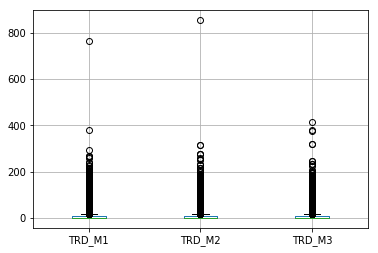

In [129]:
df_numeric.boxplot(['TRD_M1','TRD_M2','TRD_M3'])

In [130]:
#Llamamos a la función para eliminar los outliers
df_plane_num = replace_outliers(df_numeric,'Target')

In [131]:
df_plane_num.shape

(683328, 192)

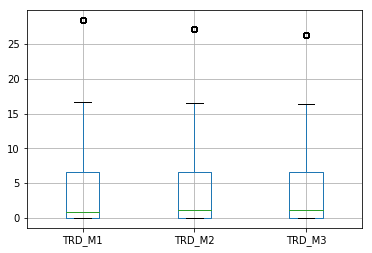

In [132]:
df_numeric.boxplot(['TRD_M1','TRD_M2','TRD_M3'])

In [133]:
df_numeric.head()

LAT_PROV_BTS  LON_PROV_BTS  LAT_CITY_BTS  LON_CITY_BTS  \
785510        8.6266      -80.3659     -80.44349       8.59299   
337081        8.5848      -82.3885     -82.44136       8.78024   
12721         9.0832      -79.5924     -79.51973       8.99360   
205417        9.0832      -79.5924     -79.51973       8.99360   
511138        9.0832      -79.5924     -79.51973       8.99360   

        TENURE_CUSTOMER  PREP_RECH_AMT_X1  PREP_RECH_AMT_X2  PREP_RECH_AMT_X3  \
785510             50.0               7.5               6.0               9.0   
337081             50.0               0.0               0.0               9.0   
12721              50.0               5.0               8.0               3.0   
205417             50.0               0.0               0.0               3.0   
511138             50.0              23.0              12.0              12.0   

        PREP_RECH_NDAYS_LASTRECH_12W  PREP_RECH_Q_EVT_W1  ...  \
785510                          10.0                 0.0  ...   
337081                          60.0                 0.0  ...   
12721                           25.0                 0.0  ...   
205417                          69.0                 0.0  ...   
511138                           3.0                 3.0  ...   

        MICROSEGMENTATION_PD3  MICROSEGMENTATION_PV1  MICROSEGMENTATION_PV2  \
785510                    0.0                    0.0                    0.0   
337081                    0.0                    0.0                    0.0   
12721                     0.0                    0.0                    0.0   
205417                    0.0                    0.0                    0.0   
511138                    0.0                    0.0                    0.0   

        MICROSEGMENTATION_PV3  MICROSEGMENTATION_VD1  MICROSEGMENTATION_VD2  \
785510                    0.0                    0.0                    0.0   
337081                    0.0                    0.0                    0.0   
12721                     0.0                    0.0                    0.0   
205417                    0.0                    0.0                    0.0   
511138                    0.0                    0.0                    0.0   

        MICROSEGMENTATION_VD3  NETWORK_TECH_2G  NETWORK_TECH_3G  \
785510                    0.0              0.0              0.0   
337081                    0.0              0.0              0.0   
12721                     0.0              0.0              1.0   
205417                    0.0              0.0              0.0   
511138                    0.0              0.0              1.0   

        NETWORK_TECH_LTE  
785510               1.0  
337081               1.0  
12721                0.0  
205417               1.0  
511138               0.0  

[5 rows x 192 columns]

### Correlaciones

En esta sección analizaremos las correlaciones entre todas las variables con el target, para descartar los que esten muy correlacionadas entre sí, y para dejar fuera variables que casi no tienen correlacion con el target.


In [134]:
def fetch_features(df, name_y='Target'):
    """
    Funcion para obtener las variables ordenadas con mayor correlacion con respecto al target
    Recibe como parametro la variable a predecir.
    Devuelve un data frame con las variables ordenadas y su correlación con el target.
    """
    name_x=[]
    cors=[]
    
    for i in df.columns:
        if not i ==name_y:
            name_x.append(i)
            cors.append(df[name_y].corr(df[i]))
            
    return pd.DataFrame({
        "name":name_x,
        "cors": cors,
        "abs_cors": np.fabs(cors)
    })

In [135]:
#Llamo a la funcion que devuelve la correlación de cada variable con el Target y las ordeno
best_corr=fetch_features(df_numeric, 'Target').sort_values('abs_cors', ascending=False)
best_corr.head(20)

name      cors  abs_cors
8    PREP_RECH_NDAYS_LASTRECH_12W  0.554368  0.554368
5                PREP_RECH_AMT_X1 -0.503609  0.503609
162            SEGMENTATION_7-LOW  0.479398  0.479398
57                 PACK_DATA_Q_X1 -0.457718  0.457718
137              PACK_DATA_EXP_W1 -0.441429  0.441429
10             PREP_RECH_Q_EVT_W2 -0.441063  0.441063
9              PREP_RECH_Q_EVT_W1 -0.428727  0.428727
138              PACK_DATA_EXP_W2 -0.428302  0.428302
155      VALUE_SEGMENT_4 - BRONZE  0.412035  0.412035
22               PREP_RECH_AMT_W2 -0.410711  0.410711
66                 PACK_DATA_Q_W2 -0.401140  0.401140
139              PACK_DATA_EXP_W3 -0.398919  0.398919
65                 PACK_DATA_Q_W1 -0.396830  0.396830
21               PREP_RECH_AMT_W1 -0.394729  0.394729
12             PREP_RECH_Q_EVT_W4 -0.393552  0.393552
11             PREP_RECH_Q_EVT_W3 -0.391908  0.391908
6                PREP_RECH_AMT_X2 -0.387211  0.387211
77               PACK_DATA_AMT_W1 -0.384616  0.384616
78               PACK_DATA_AMT_W2 -0.374366  0.374366
140              PACK_DATA_EXP_W4 -0.373798  0.373798

In [136]:
#paso a una lista los nombres de las variables con mayor correlación
#Puedo jugar con la cantidad para ver cómo se comporta el modelo
lst=list(best_corr.head(25).name)
#agrego el nombre de la variable objetivo
lst.append('Target')

In [137]:
#creo un nuevo data frame formado por las columnas de mayor correlación y el vector objetivo
df_best_corr= df_numeric[[c for c in df_numeric.columns if c in lst]]

#### Ahora analizaremos correlaciones entre variables combinadas o sumarizadas con el target

In [138]:
#Analizamos la correlación entre el target y los que no hicieron recargas las últimas 4 semana
#Aquí seleccionamos las variables que registran la cantidad de recargas en las 4 semanas mas próximas y el target
df_cols= df_numeric[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4','Target']]

In [139]:
#tal como hicimos con el data set de TAG creamos una columna para sumar el total de recargas de estas semanas
df_cols['Total'] = df_cols[df_cols.columns[:4]].sum(axis=1);
df_cols['Total']=df_cols['Total']<1
df_cols['Total'] = df_cols['Total'].astype(int)

In [140]:
#ahora llamamos a la fucnión de correlación
best_corr=fetch_features(df_cols, 'Target').sort_values('abs_cors', ascending=False)
best_corr.head()

name      cors  abs_cors
4               Total  0.506498  0.506498
1  PREP_RECH_Q_EVT_W2 -0.441063  0.441063
0  PREP_RECH_Q_EVT_W1 -0.428727  0.428727
3  PREP_RECH_Q_EVT_W4 -0.393552  0.393552
2  PREP_RECH_Q_EVT_W3 -0.391908  0.391908

Observamos que la correlación es moderada de 0.499, por lo que vamos a eliminar estas variables ya que el aporte que hacen para la el modelo no tiene demasiado valor, ya que si hacemos un analisis de negocio, cuando se tengan estos datos y se sepa que el cliente no recargo en las ultimas 4 semanas probablemnte ya sea muy tarde para intentar retenerlo. Lo que que intentamos es detectar el comportamiento antes.

In [141]:
#Graficaremos en un heatmap las correlaciones en el data frame df_corr
corr = df_best_corr.corr()

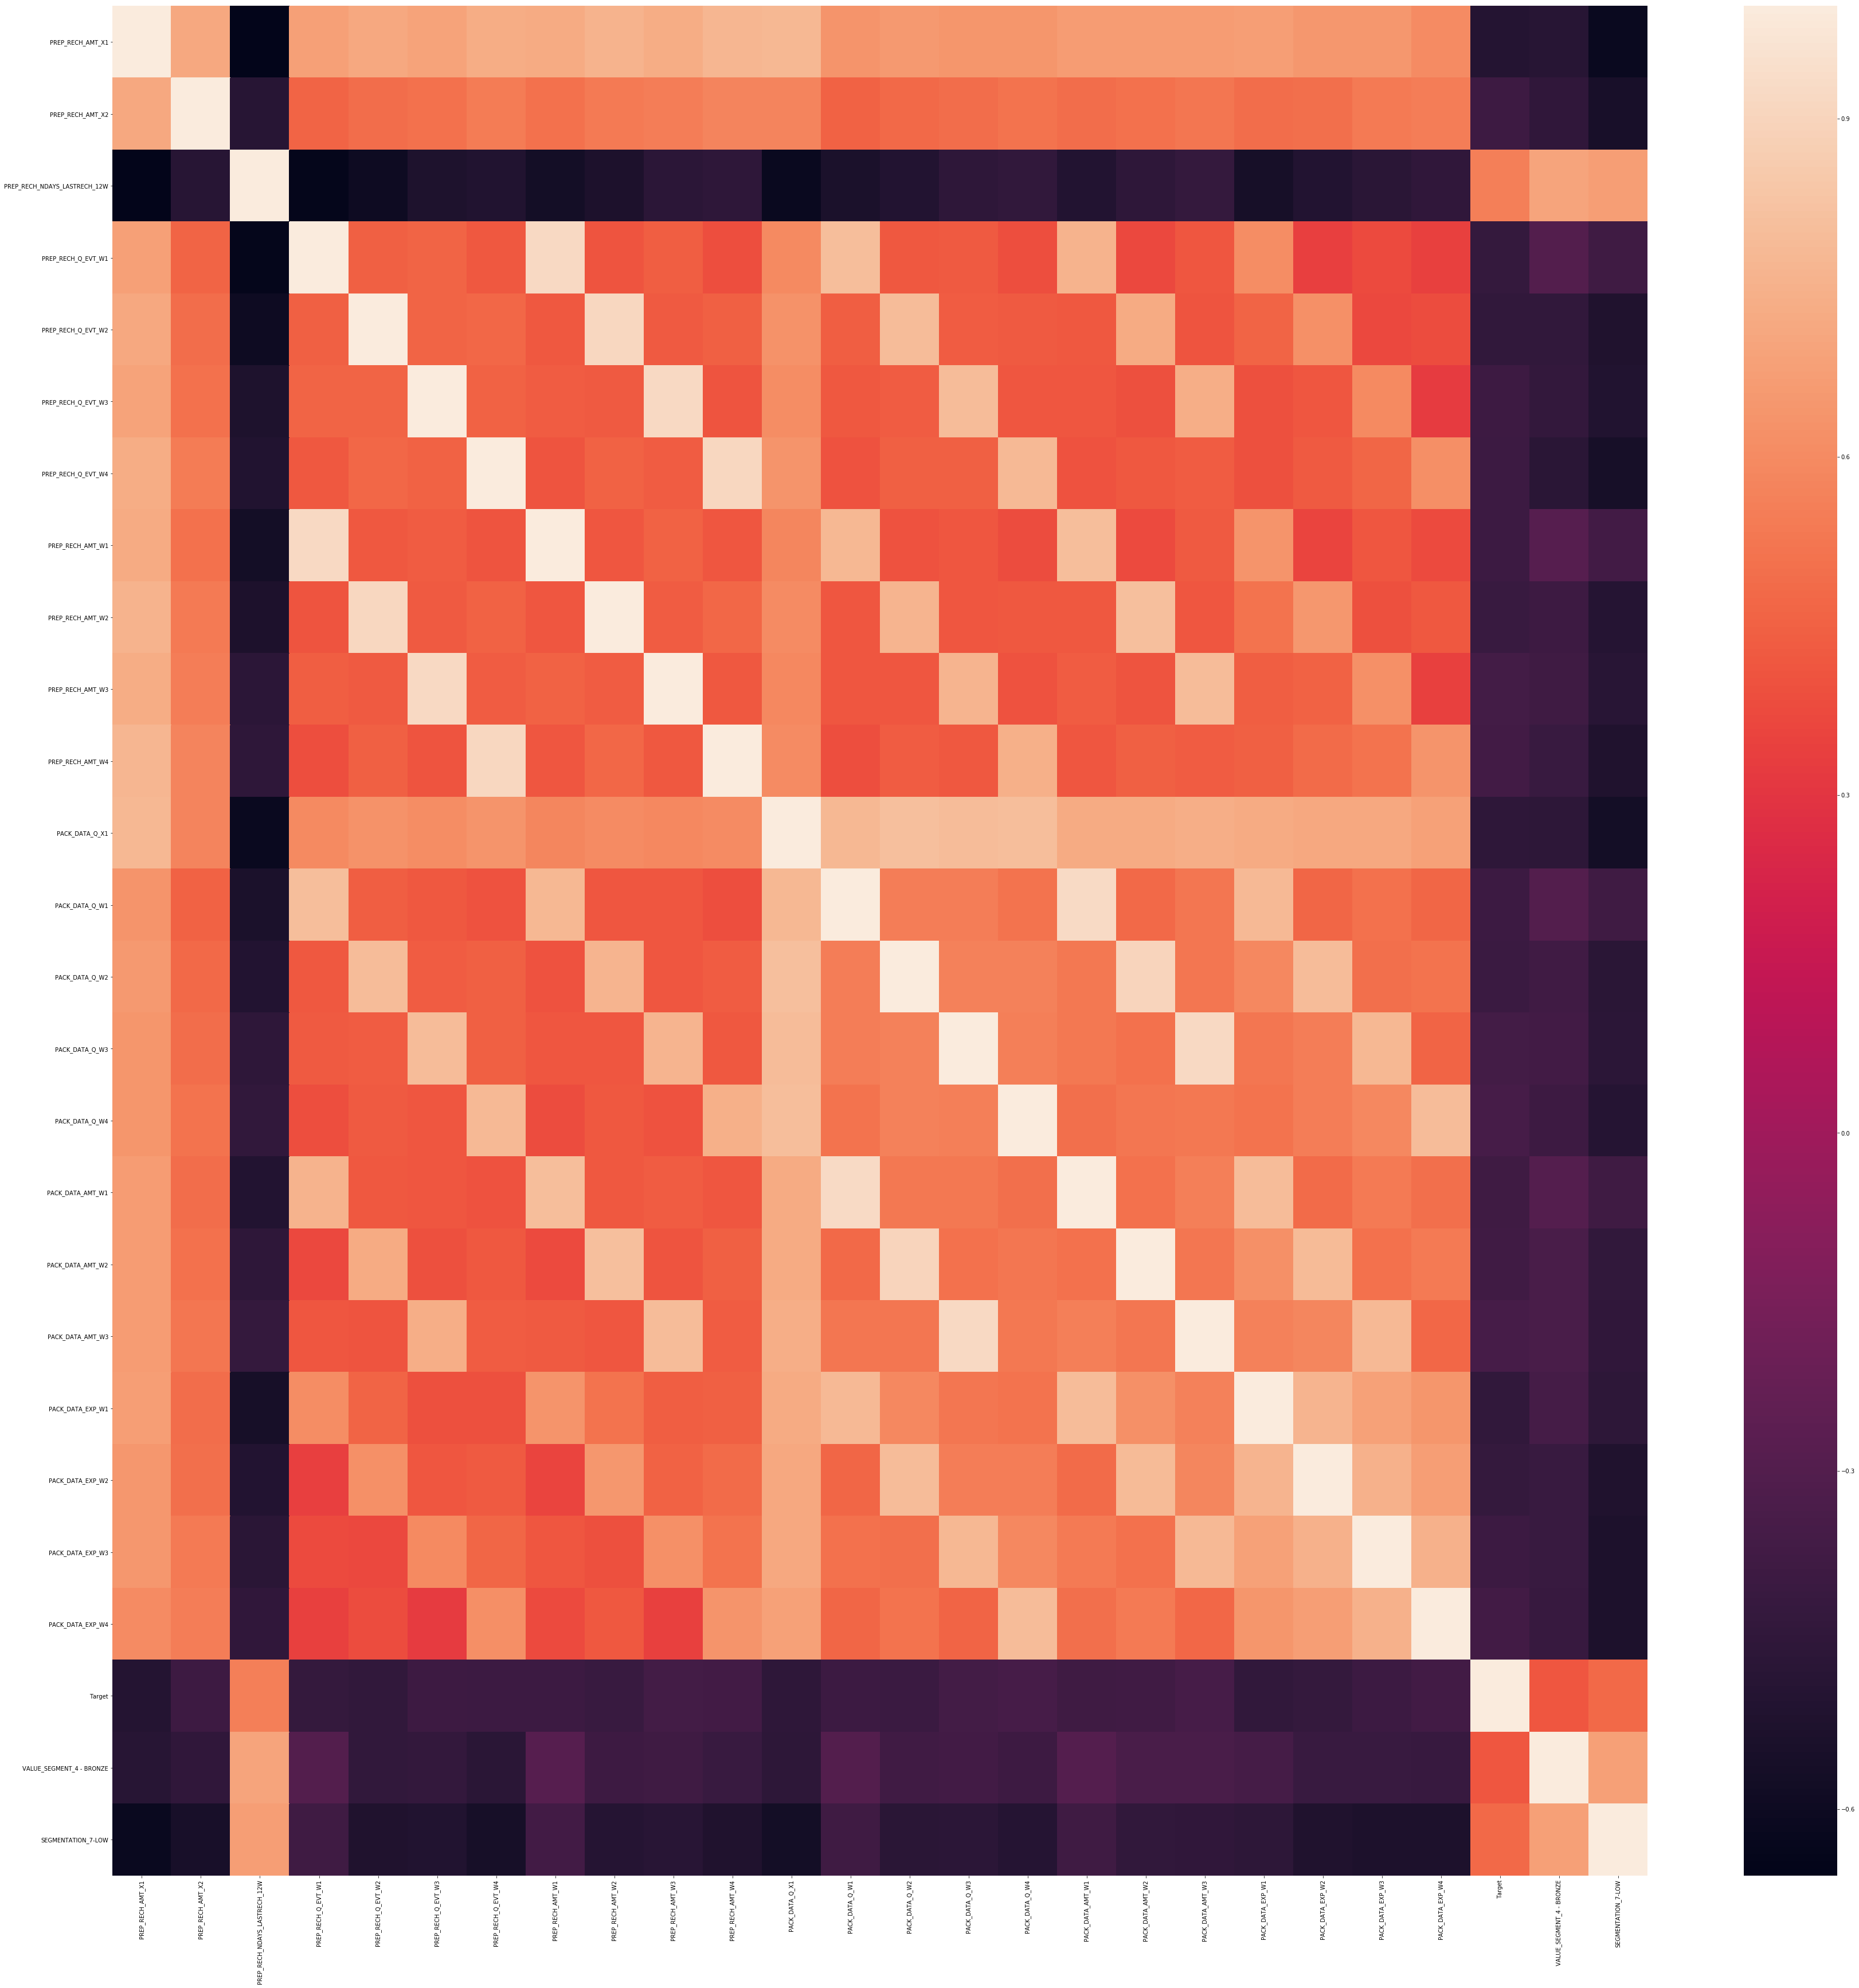

In [142]:
plt.figure(figsize=(60,60))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


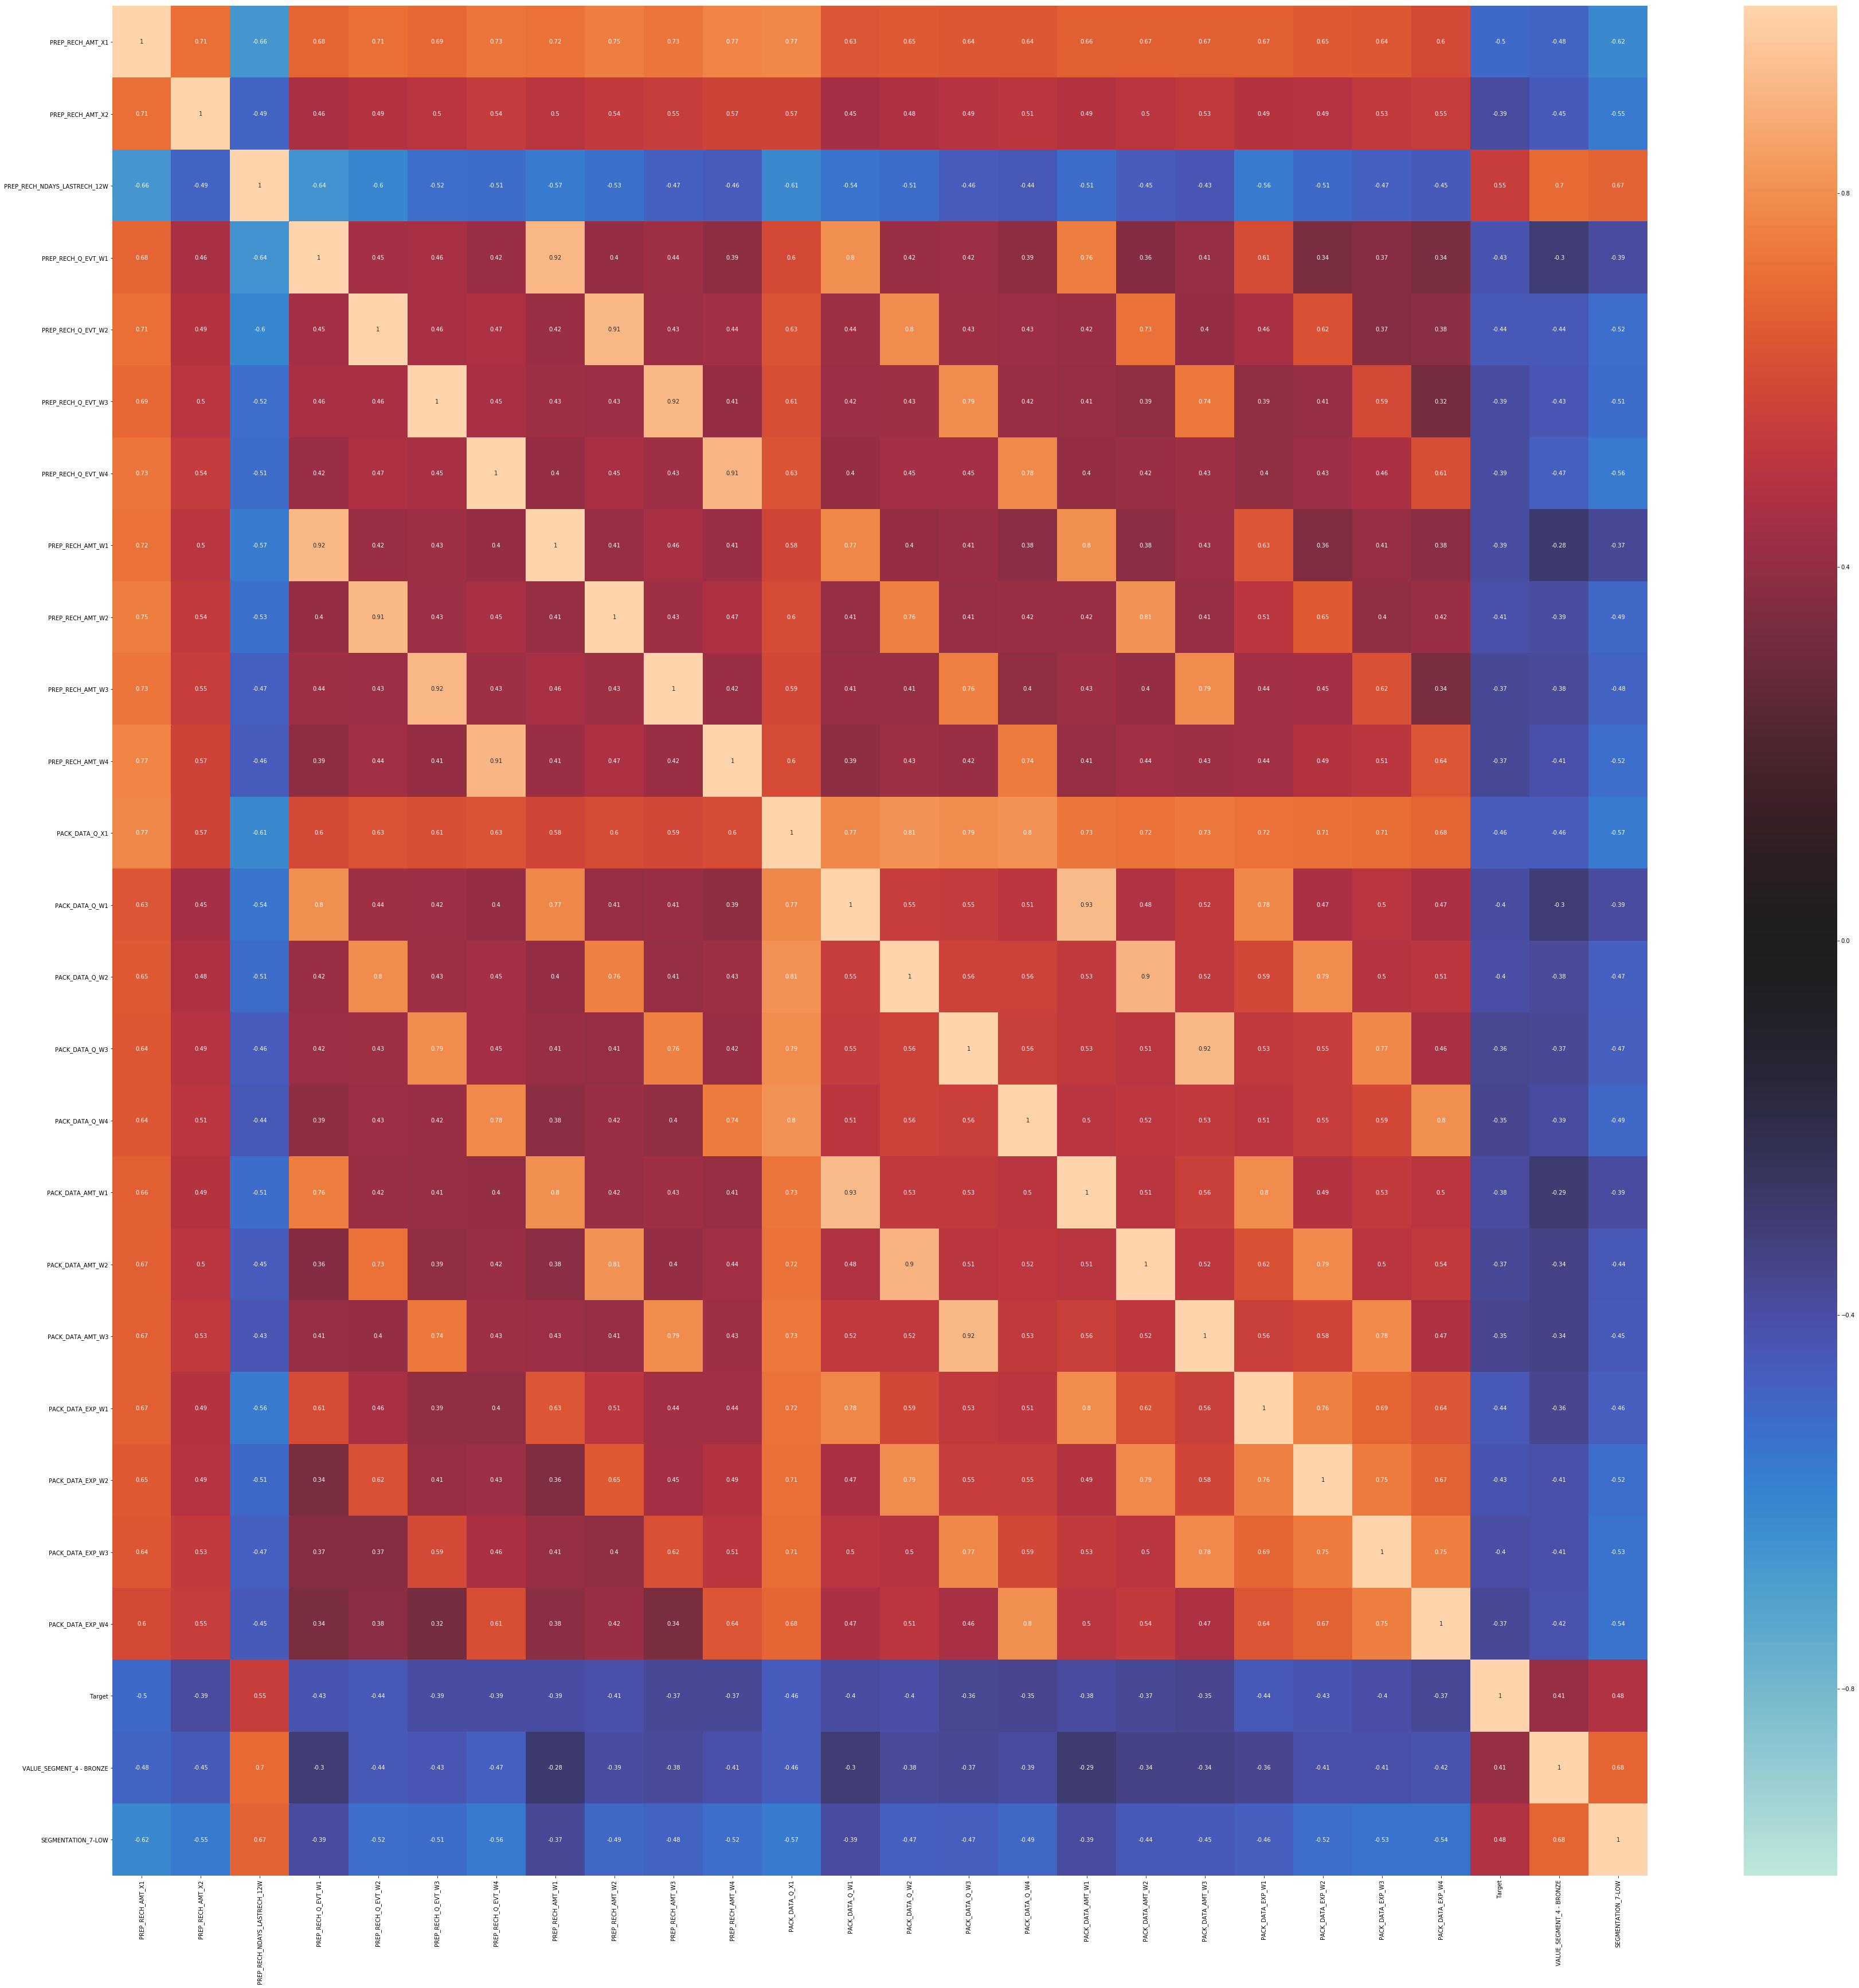

In [143]:
plt.figure(figsize=(60,60))
# plot the heatmap
sns.heatmap(corr, 
        annot = True, vmin=-1, vmax=1, center= 0,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

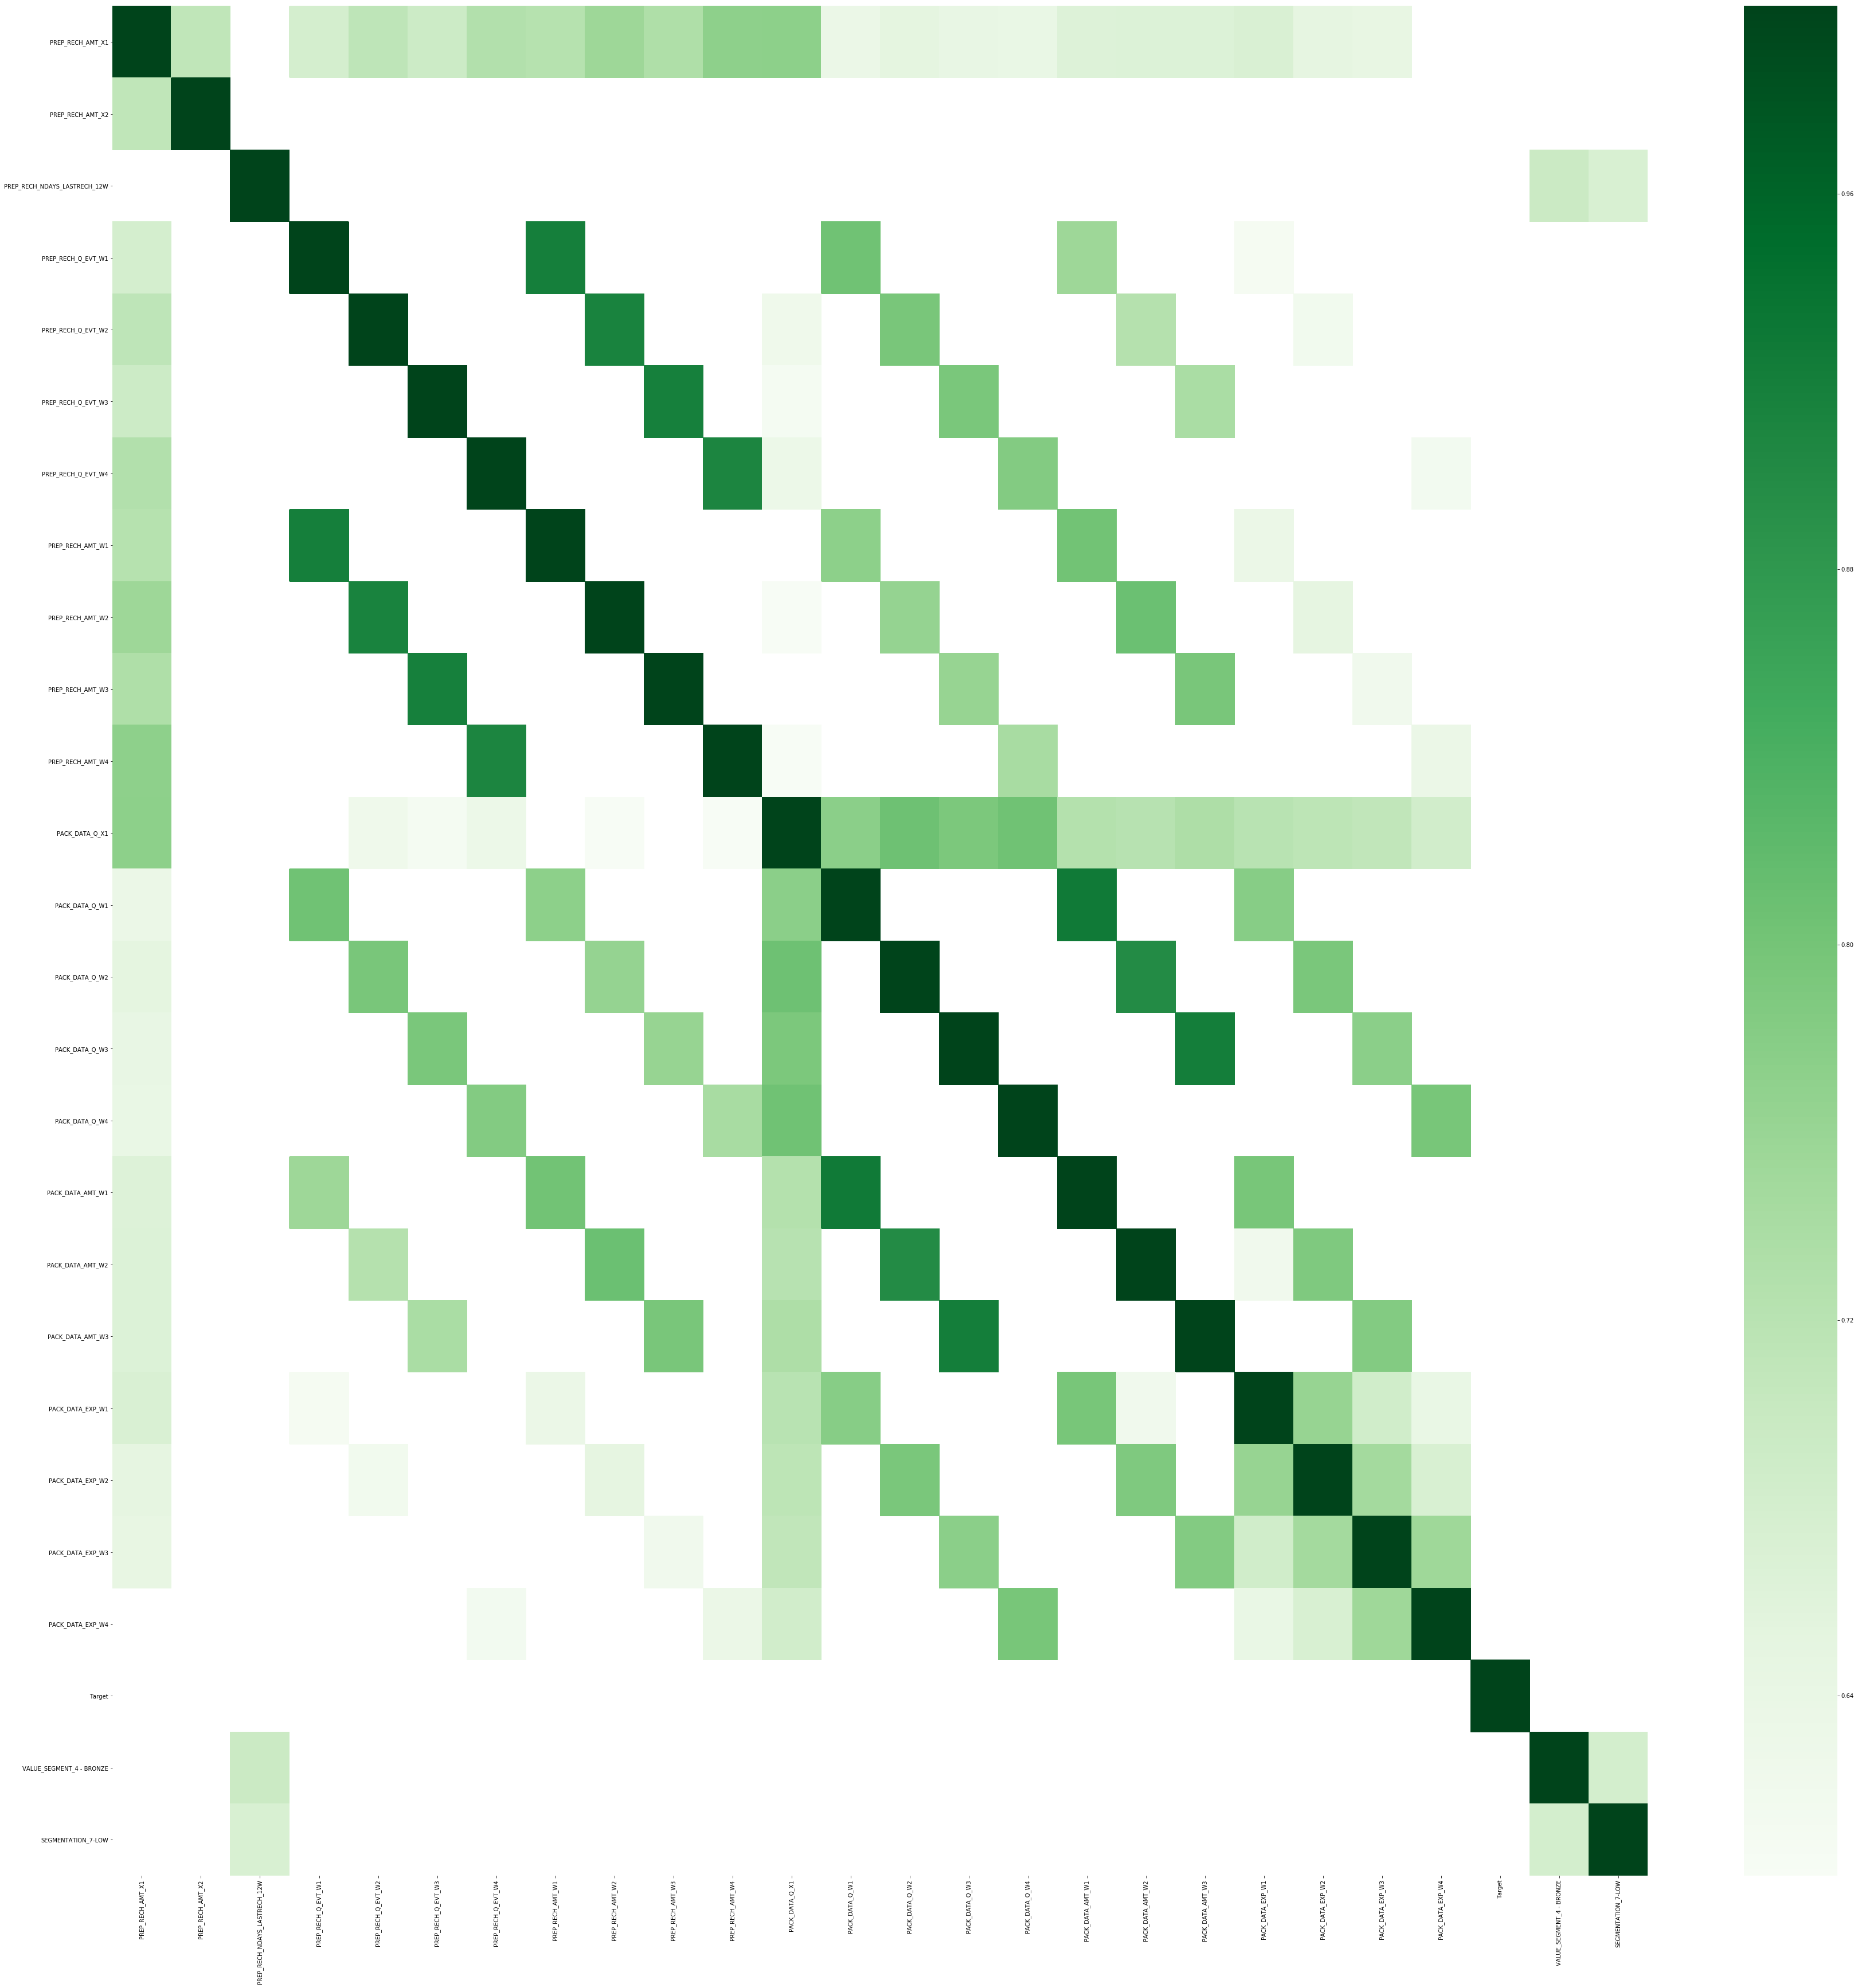

In [144]:
kot = corr[corr>=.6]
plt.figure(figsize=(60,60))
sns_plot = sns.heatmap(kot, cmap="Greens")
sns_plot.figure.savefig("output.png")

Train test
Debemos separar el modelo en 2 partes:
    * Conjunto entrenamiento 
    * Conjunto de test
Entonces a partir del conjunto de entrenamiento, entrenamos el modelo, y una vez que conseguimos un modelo predictivo, con el conjunto de test testeamos el modelo para ver que tan bien funciona

Necesitamos hacer una division de lo que se considera datos de entrenamiento (data) y el resultado a obtener (tag)

In [145]:
df_best_corr.shape

(683328, 26)

In [146]:
df_best_corr.head()

PREP_RECH_AMT_X1  PREP_RECH_AMT_X2  PREP_RECH_NDAYS_LASTRECH_12W  \
785510               7.5               6.0                          10.0   
337081               0.0               0.0                          60.0   
12721                5.0               8.0                          25.0   
205417               0.0               0.0                          69.0   
511138              23.0              12.0                           3.0   

        PREP_RECH_Q_EVT_W1  PREP_RECH_Q_EVT_W2  PREP_RECH_Q_EVT_W3  \
785510                 0.0                 3.0                 0.0   
337081                 0.0                 0.0                 0.0   
12721                  0.0                 0.0                 0.0   
205417                 0.0                 0.0                 0.0   
511138                 3.0                 3.0                 3.0   

        PREP_RECH_Q_EVT_W4  PREP_RECH_AMT_W1  PREP_RECH_AMT_W2  \
785510                 4.0               0.0               3.0   
337081                 0.0               0.0               0.0   
12721                  3.0               0.0               0.0   
205417                 0.0               0.0               0.0   
511138                 4.0               5.0               5.0   

        PREP_RECH_AMT_W3  ...  PACK_DATA_AMT_W1  PACK_DATA_AMT_W2  \
785510               0.0  ...              0.00              0.00   
337081               0.0  ...              0.00              0.00   
12721                0.0  ...              0.99              0.99   
205417               0.0  ...              0.00              0.00   
511138               5.0  ...              4.98              5.00   

        PACK_DATA_AMT_W3  PACK_DATA_EXP_W1  PACK_DATA_EXP_W2  \
785510               0.0               0.0               0.0   
337081               0.0               0.0               0.0   
12721                0.0               9.0               6.0   
205417               0.0               0.0               0.0   
511138               5.0              14.0              10.0   

        PACK_DATA_EXP_W3  PACK_DATA_EXP_W4  Target  VALUE_SEGMENT_4 - BRONZE  \
785510               0.0               0.0       0                       0.0   
337081               0.0               0.0       0                       1.0   
12721                0.0               8.0       1                       0.0   
205417               0.0               0.0       1                       1.0   
511138               9.0               9.0       0                       0.0   

        SEGMENTATION_7-LOW  
785510                 0.0  
337081                 1.0  
12721                  0.0  
205417                 1.0  
511138                 0.0  

[5 rows x 26 columns]

In [147]:
#Nuestro tag estara dado por la columna target, al que llamaremos y 
y = df_best_corr['Target']

Ahora tenemos que crear la variable x que contendra la informacion para el entrenamiento del modelo (data)

Tenemos que quitar la columna SUSCRIBER_KEY que es una columna de valores unicos y que solo sirve para identificar a cada linea, pero no para entrenar el modelo. Y obviamente tampoco tiene sentido poner la columna Target dentro de los datos de 
entrenamiento, sino el modelo va a conocer perfectamente que persona abandona o no el servicio
Otras columnas que eliminaremos del modelo seran commercial_activation_data, date, dayofweek, month, year, period
ya que ya hicimos su analisis y las utilizamos pero ya no tienen mas sentido

Y solamente tomamos en cuenta las columnas que son numericas

In [148]:
columns = [col for col in df_best_corr.columns if col not in [ 'SUSCRIBER_KEY', 'Target', 'COMMERCIAL_ACTIVATION_DATE', 'Date', 'Dayofweek', 'Month', 'Year', 'Period']]

In [149]:
X = df_best_corr[columns]

In [150]:
#ahora nos quedamos con los valores de cada variable
#values pasa de serie a array
y = y.values
X = X.values

Ahora que tenemos las dos variables X e y, debemos realizar una division del dataset en un dataset de entrenamiento y uno de testeo

Usaremos el metodo Train Test Split, el cual se encarga de dividir nuestro conjunto original en un conjunto de entrenamiento y un conjunto de testeo

In [151]:
from sklearn.model_selection import train_test_split # cargamos el metodo

In [152]:
#Separamos el conjunto entrenamiento y test con el metodo train_test_split y se lo asignamos a las distintas variables
X_train, X_test, y_train, y_test = train_test_split(X,y)
#por default el conjunto se separara en 75% para el train y 25% para el test

In [153]:
X.shape

(683328, 25)

In [154]:
X_train.shape

(512496, 25)

In [155]:
X_test.shape

(170832, 25)

Podemos observar que como separamos la variable X en train y test, la suma de registros de X_train y X_test 
dara la cantidad de registros de X. En el caso de la variable y ocurriria exactamente igual.

A su vez, X_train tendra la misma cantidad de registros o filas que y_train, y X_test la misma que y_test.

In [156]:
#utilizaremos xgboost como modelo predictivo
!pip install xgboost

In [157]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#estas herramientas nos permiten calcular metricas del modelo 

In [158]:
def train(X_train,y_train):
    """
    Función para entrenar el modelo.
    
    Parameters
    -----------
    
    X_train: pd.DataFrame
        Dataset de Train, listo para entrenar y sin tag
        
    y_train: pd.DataFrame
        Dataset de tag, es el tag correspondiente al dataset de train.
        
    Return
    ----------
    Modelo Entrenado.
    
    """
    xgb_model = xgb.XGBClassifier()
    #instanciamos el clasificador xgb
    
    print("Comienza entrenamiento del modelo XGBoost")

    xgb_model.fit(X_train, y_train)
    #el metodo fit llama al modelo matematico que entrenara el modelo 
    #xgb model ahora va a ser un modelo entrenado
    
    print("Entrenamiento finalizado\n")

    print("Haciendo las predicciones\n\n")

    #con este modelo ya entrenado llamo al metodo predict
    XGB_preds = xgb_model.predict(X_test)
    #comparo mis predicciones con el valor real que tengo guardo en y_test 
    print(classification_report(y_test, XGB_preds))
    print(confusion_matrix(y_test, XGB_preds))
    return xgb_model

In [159]:
def predict(data_to_predict, xgb_model):
    """Funcion para hacer el entrenamiento del modelo y guardarlo en un archivo .pkl

    Parameters
    -----------

    data_to_predict : pd.DataFrame
        DataFrame listo para predecir, con las mismas transformaciones que el de entrenamiento.
        
    xgb_model : xgb.XGBClassifier
        Modelo entrenado de XGBoost

    Return
    -----------
    Dataframe de 3 columnas, la identificacion del cliente, la prediccion de la clase y la probabilidad de que el cliente
    permanezca en el servicio.


    """
    print("\n\n-------------------------")
    print("Ingreso a la funcion de prediccion\n")

    XGB_preds = xgb_model.predict_proba(X)
    #si en vez de un predict proba hacemos un predict nos daria como resultado 0 y 1 directamente, redondeando
    
    return XGB_preds

In [160]:
modelo = train(X_train, y_train)

Comienza entrenamiento del modelo XGBoost
Entrenamiento finalizado

Haciendo las predicciones


              precision    recall  f1-score   support

           0       0.87      0.87      0.87    117748
           1       0.71      0.70      0.70     53084

   micro avg       0.82      0.82      0.82    170832
   macro avg       0.79      0.78      0.79    170832
weighted avg       0.82      0.82      0.82    170832

[[102296  15452]
 [ 15925  37159]]


Obtenemos la prediccion del modelo La metrica que mas interesa ver es f1-score .. 
vemos qeue el modelo predice mejor 0s que 1s, tiene sentido porque tenemos mas 0s que 1s entre los datos

In [161]:
resultado = predict(X_test,modelo)



-------------------------
Ingreso a la funcion de prediccion



In [162]:
resultado
#podemos ver un array con las probabilidades de que cada registro valga 0 o 1
#por ejemplo en el primer registro tenemos 86% de probabilidades de que valga 0, y 13% de que valga 1

array([[0.85715544, 0.14284457],
       [0.22212088, 0.7778791 ],
       [0.91674656, 0.08325347],
       ...,
       [0.19761044, 0.80238956],
       [0.42367214, 0.57632786],
       [0.19761044, 0.80238956]], dtype=float32)

In [163]:
resultado = pd.DataFrame(resultado)

In [164]:
#podriamos determinar por ejemplo que tengan 1 aquellos que tengan un valor de probabilidad mayor a 0.6 
(resultado[1] > 0.6).astype(int)

0         0
1         1
2         0
3         1
4         0
5         0
6         0
7         1
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        1
17        0
18        0
19        0
20        0
21        0
22        0
23        1
24        0
25        1
26        1
27        0
28        0
29        0
         ..
683298    1
683299    0
683300    0
683301    1
683302    0
683303    0
683304    0
683305    0
683306    0
683307    1
683308    1
683309    1
683310    0
683311    0
683312    1
683313    1
683314    1
683315    1
683316    0
683317    0
683318    0
683319    0
683320    1
683321    0
683322    1
683323    1
683324    0
683325    1
683326    0
683327    1
Name: 1, Length: 683328, dtype: int32

In [165]:
pd.DataFrame(resultado).to_csv('resultado.csv')

In [166]:
xgb_model = xgb.XGBClassifier()

In [167]:
%time
xgb_model.fit(X_train, y_train)

Wall time: 0 ns


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [168]:
XGB_preds = xgb_model.predict(X_test)

In [169]:
#podemos ver la matriz de confusion donde tenemos 
#verdaderos negativos        falsos positivos
#falsos negativos           verdaderos positivos
print(confusion_matrix(y_test, XGB_preds))

[[102296  15452]
 [ 15925  37159]]


In [170]:
#pero lo que estaria bueno poder observar ahora es la curva roc y el area bajo la curva
#para esto necesitamos importar otra libreria de sklearns
import sklearn.metrics as metrics

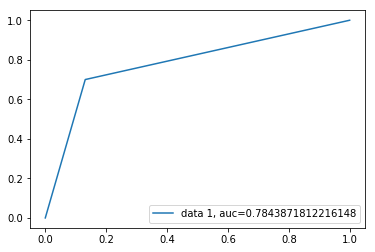

In [171]:
#ahora procedemos a graficar nuestra curva roc por primera vez 
fpr, tpr, _ = metrics.roc_curve(y_test, XGB_preds)
auc = metrics.roc_auc_score(y_test, XGB_preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc)),
plt.legend(loc=4)
plt.show()

In [172]:
#podemos ver tambien de la siguiente manera nuestra curva roc 
from plotly import express as px

In [173]:
px.line(x=fpr,y=tpr)

In [174]:
#en vez de realizar el calculo con predict podemos hacer uso de la funcion predict proba 
#para este caso trabajremos de la siguiente manera 
XGB_preds_proba = xgb_model.predict_proba(X_test)

In [175]:
#del array obtenido me quedo solo con la probabilidad de que sean 1s 
XGB_preds_proba = XGB_preds_proba[:,[1]]

In [176]:
#ahora puedo aplicar un umbral donde deseo obtener todos aquellos cuya probabilidad sean mayor a 0.5
#los que sean mayor a 0.5 daran true y el resto dara false
XGB_preds_proba[:,0]>0.5

array([ True, False, False, ..., False, False,  True])

In [177]:
#vamos a comparar cuantos 1s tenemos con esta probabilidad y cuantos 1s teniamos haciendo la predicion sin probabilidad
(XGB_preds_proba[:,0]>0.5).sum()

52611

In [178]:
XGB_preds.sum()

52611

In [179]:
#vemos que cuando la probabilidad tomada como umbral es 0.5 tenemos la misma cantidad de 1s en ambos casos, ya que el
#0.5 es el umbral por defecto pero si vamos jugando con nuestro umbral obtendremos mas o menos 1s como resultado
(XGB_preds_proba[:,0]>0.6).sum()

42400

In [180]:
result1 = XGB_preds_proba[:,0]>0.3
result2 = XGB_preds_proba[:,0]>0.5
result3 = XGB_preds_proba[:,0]>0.7

#veremos con estas variables como va cambiando las metricas y como va quedando nuestra curva roc

In [181]:
print(classification_report(y_test, result1))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84    117748
           1       0.62      0.85      0.72     53084

   micro avg       0.79      0.79      0.79    170832
   macro avg       0.77      0.81      0.78    170832
weighted avg       0.82      0.79      0.80    170832



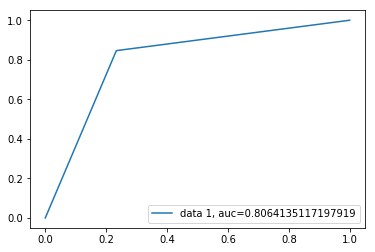

In [182]:
fpr, tpr, _ = metrics.roc_curve(y_test, result1)
auc = metrics.roc_auc_score(y_test, result1)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc)),
plt.legend(loc=4)
plt.show()

In [183]:
print(classification_report(y_test, result2))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87    117748
           1       0.71      0.70      0.70     53084

   micro avg       0.82      0.82      0.82    170832
   macro avg       0.79      0.78      0.79    170832
weighted avg       0.82      0.82      0.82    170832



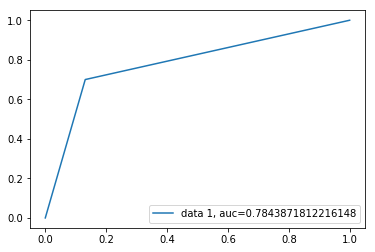

In [184]:
fpr, tpr, _ = metrics.roc_curve(y_test, result2)
auc = metrics.roc_auc_score(y_test, result2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc)),
plt.legend(loc=4)
plt.show()

In [185]:
print(classification_report(y_test, result3))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86    117748
           1       0.79      0.43      0.56     53084

   micro avg       0.79      0.79      0.79    170832
   macro avg       0.79      0.69      0.71    170832
weighted avg       0.79      0.79      0.77    170832



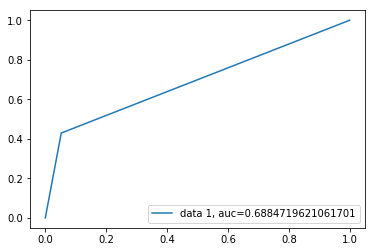

In [186]:
fpr, tpr, _ = metrics.roc_curve(y_test, result3)
auc = metrics.roc_auc_score(y_test, result3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc)),
plt.legend(loc=4)
plt.show()

In [187]:
#podemos observar asi que podriamos quedarnos con el umbral de 0.5 o de 0.7 dependiendo el caso y analizando bien
#poero por ejemplo vemos que el umbral de 0.3 , que equivale al result3, sin dudas no es aceptable 